# Dataset 1- monthly_retail_sales.csv


## Step 1: Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


# Generate the dataset
dates = pd.date_range(start='2015-01-01', periods=1000, freq='M')
np.random.seed(42)
sales = np.random.normal(loc=1500, scale=300, size=len(dates)).cumsum()/10 + 1000
promo = np.random.randint(4000, 8000, size=len(dates))
online = np.linspace(5, 15, len(dates)) + np.random.normal(0, 1, len(dates))
cust = np.linspace(1200, 2000, len(dates)) + np.random.normal(0, 50, len(dates))

sales_df = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'Promotions_Spend': promo,
    'Online_Sales (%)': online,
    'Customers': cust
})

# Define the output path (with proper escaping for spaces)
output_path = '/content/Book1.csv'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Save to CSV
sales_df.to_csv(output_path, index=False)

print(f"Dataset successfully saved to: {output_path}")

Dataset successfully saved to: /content/Book1.csv


/tmp/ipython-input-1-3958719343.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2015-01-01', periods=1000, freq='M')


In [2]:
sales_df = pd.read_csv(output_path)
sales_df.head()

Date        Sales  Promotions_Spend  Online_Sales (%)    Customers
0  2015-01-31  1164.901425              4886          3.923339  1252.974027
1  2015-02-28  1310.753496              4427          3.231379  1226.424127
2  2015-03-31  1480.184152              5328          6.275219  1197.895246
3  2015-04-30  1675.875047              5895          5.218446  1190.294941
4  2015-05-31  1818.850446              5994          4.914101  1190.887715

In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1000 non-null   object 
 1   Sales             1000 non-null   float64
 2   Promotions_Spend  1000 non-null   int64  
 3   Online_Sales (%)  1000 non-null   float64
 4   Customers         1000 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 39.2+ KB


# Step 2: Exploratory Data Analysis with Enhanced Visualizations

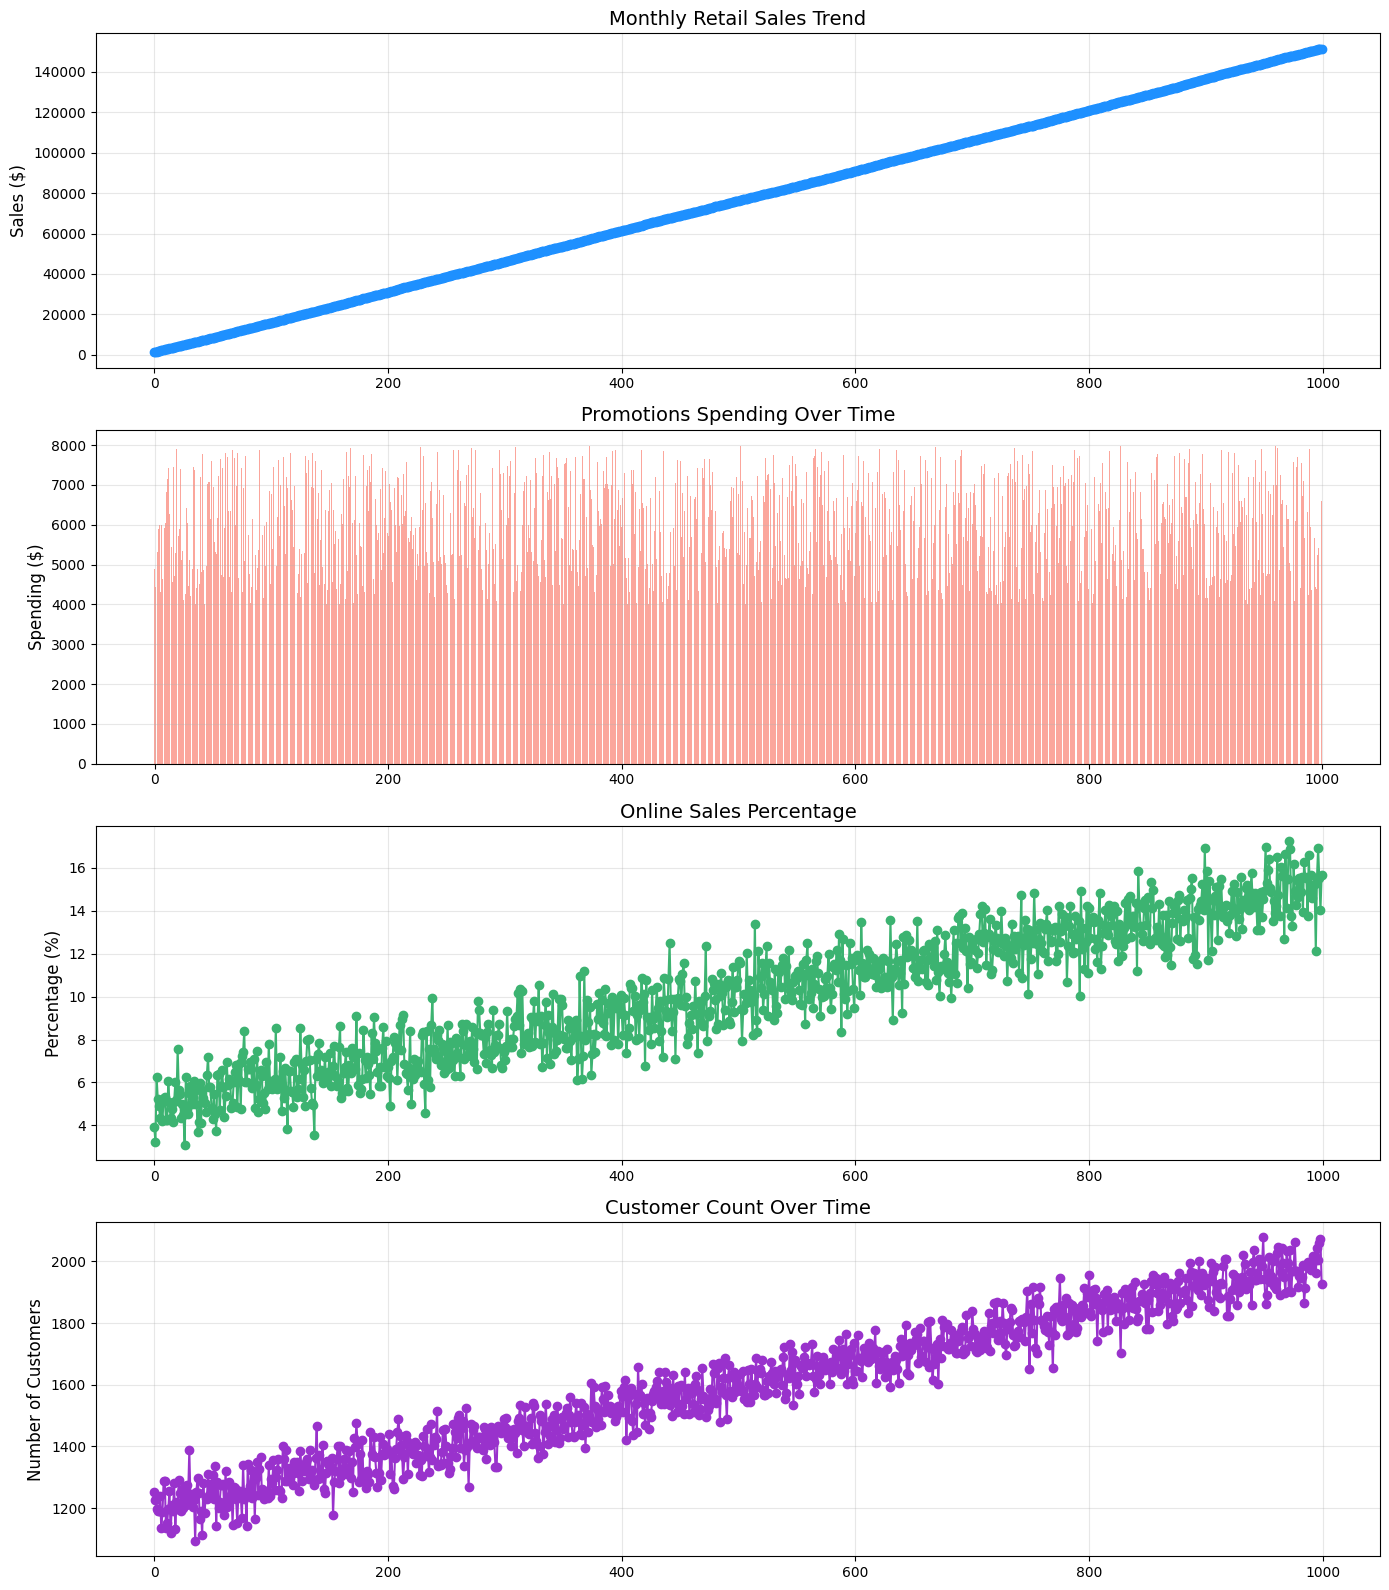

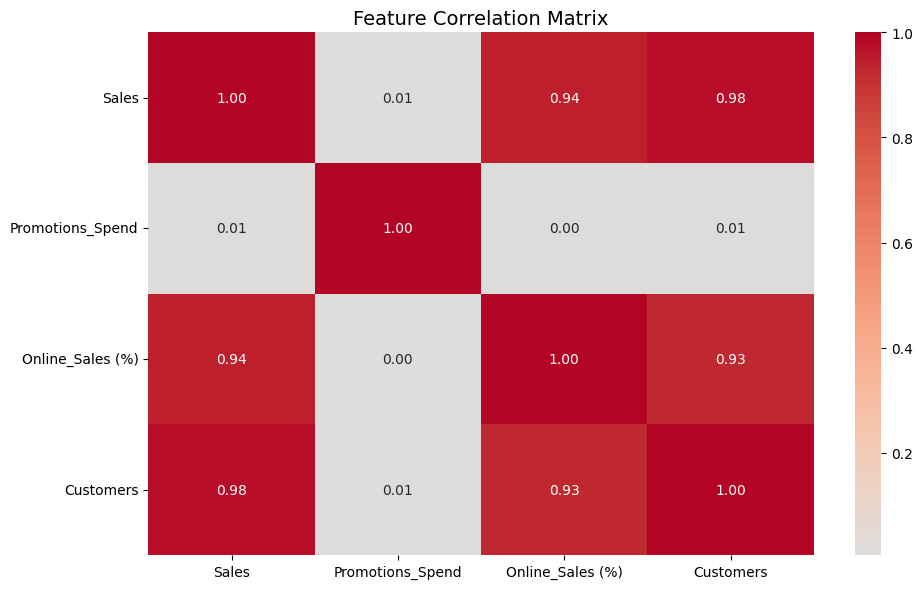

In [4]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Sales plot
axes[0].plot(sales_df.index, sales_df['Sales'], marker='o', color='dodgerblue')
axes[0].set_title('Monthly Retail Sales Trend', fontsize=14)
axes[0].set_ylabel('Sales ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Promotions plot
axes[1].bar(sales_df.index, sales_df['Promotions_Spend'], color='salmon', alpha=0.7)
axes[1].set_title('Promotions Spending Over Time', fontsize=14)
axes[1].set_ylabel('Spending ($)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Online sales percentage
axes[2].plot(sales_df.index, sales_df['Online_Sales (%)'], marker='o', color='mediumseagreen')
axes[2].set_title('Online Sales Percentage', fontsize=14)
axes[2].set_ylabel('Percentage (%)', fontsize=12)
axes[2].grid(True, alpha=0.3)

# Customers
axes[3].plot(sales_df.index, sales_df['Customers'], marker='o', color='darkorchid')
axes[3].set_title('Customer Count Over Time', fontsize=14)
axes[3].set_ylabel('Number of Customers', fontsize=12)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap (using only numeric columns)
plt.figure(figsize=(10, 6))
numeric_cols = sales_df.select_dtypes(include=[np.number])  # Select only numeric columns
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# Step 3: Data Preprocessing and Stationarity Testing

Missing Values:
 Date                0
Sales               0
Promotions_Spend    0
Online_Sales (%)    0
Customers           0
dtype: int64


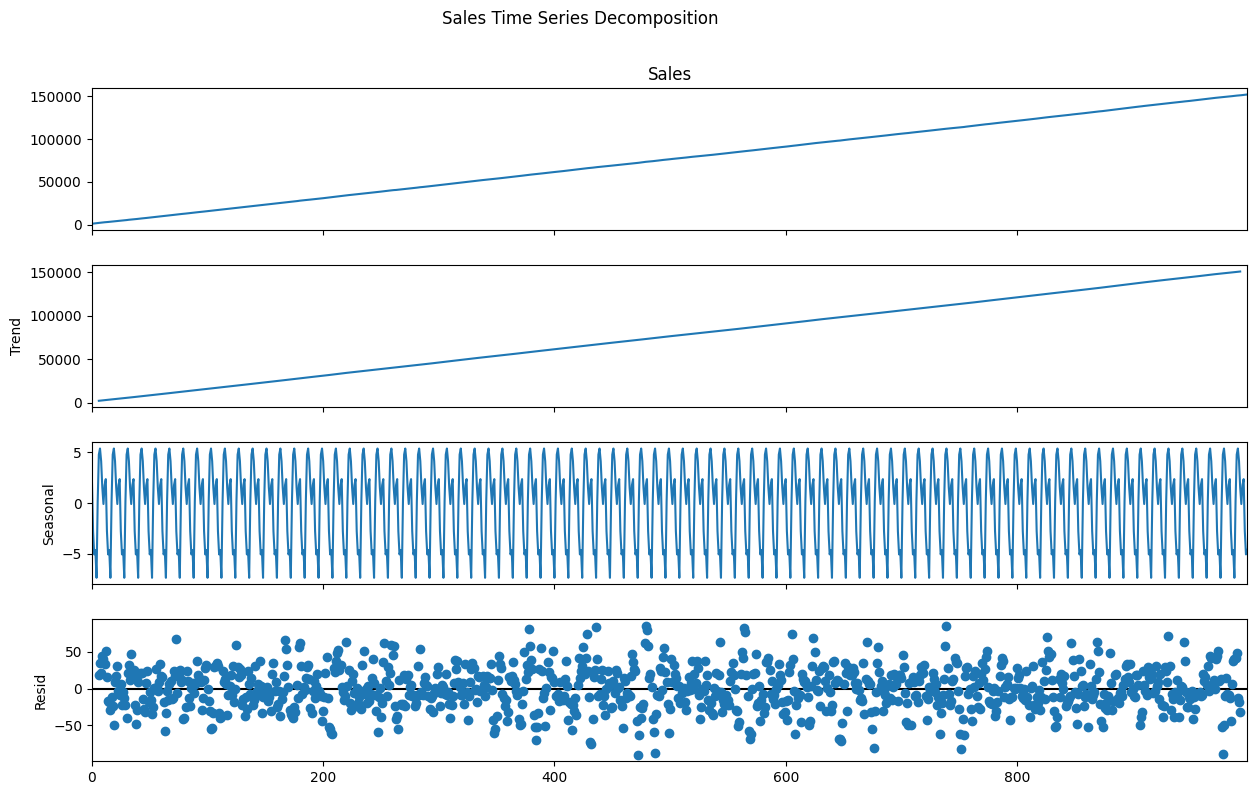

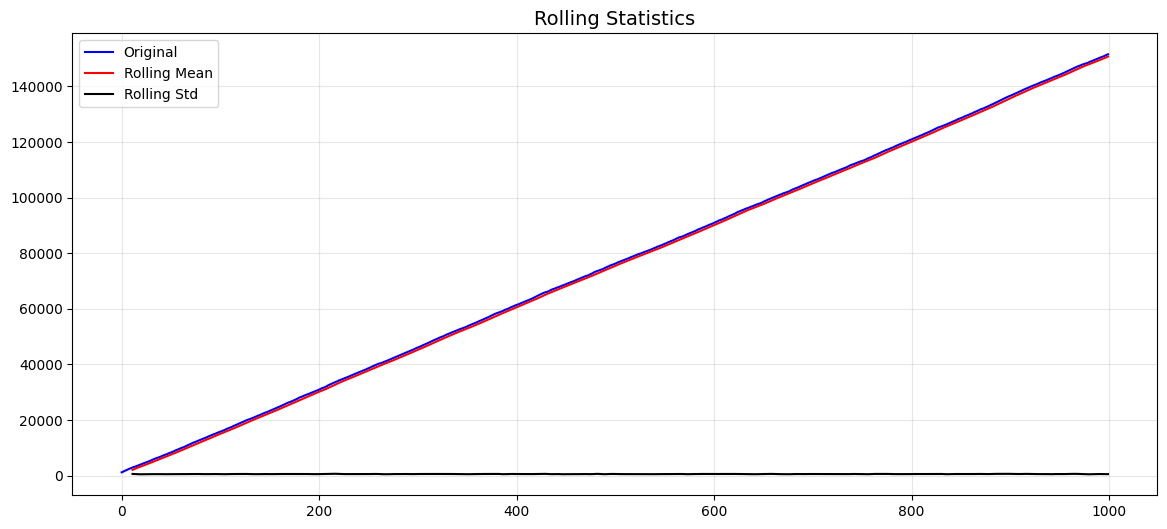

Results of Dickey-Fuller Test:
Test Statistic            1.139920
p-value                   0.995543
#Lags                     0.000000
Observations            999.000000
Critical Value (1%)      -3.436913
Critical Value (5%)      -2.864437
Critical Value (10%)     -2.568313
dtype: float64


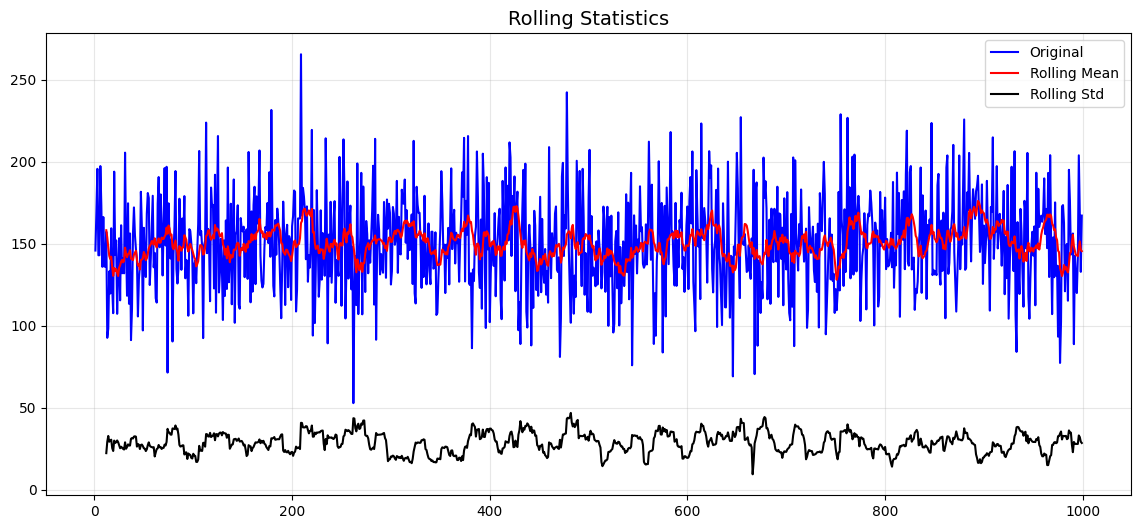

Results of Dickey-Fuller Test:
Test Statistic          -31.789311
p-value                   0.000000
#Lags                     0.000000
Observations            998.000000
Critical Value (1%)      -3.436919
Critical Value (5%)      -2.864440
Critical Value (10%)     -2.568314
dtype: float64


In [5]:
# Check for missing values
print("Missing Values:\n", sales_df.isnull().sum())

# Handle missing values if any
sales_df.fillna(method='ffill', inplace=True)

# Time series decomposition
decomposition = seasonal_decompose(sales_df['Sales'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Sales Time Series Decomposition', y=1.02)
plt.show()

# Stationarity tests
def test_stationarity(timeseries, window=12):
    # First drop any remaining NaN values
    timeseries = timeseries.dropna()

    # Rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Plot rolling statistics
    plt.figure(figsize=(14, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title('Rolling Statistics', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()

    # ADF test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')  # Ensure no NaN values
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags', 'Observations'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

test_stationarity(sales_df['Sales'])

# Differencing if needed
sales_df['Sales_diff'] = sales_df['Sales'].diff()
sales_df['Sales_diff'].dropna(inplace=True)  # Drop NA values after differencing
test_stationarity(sales_df['Sales_diff'])

# Step 4: Model Identification with ACF/PACF

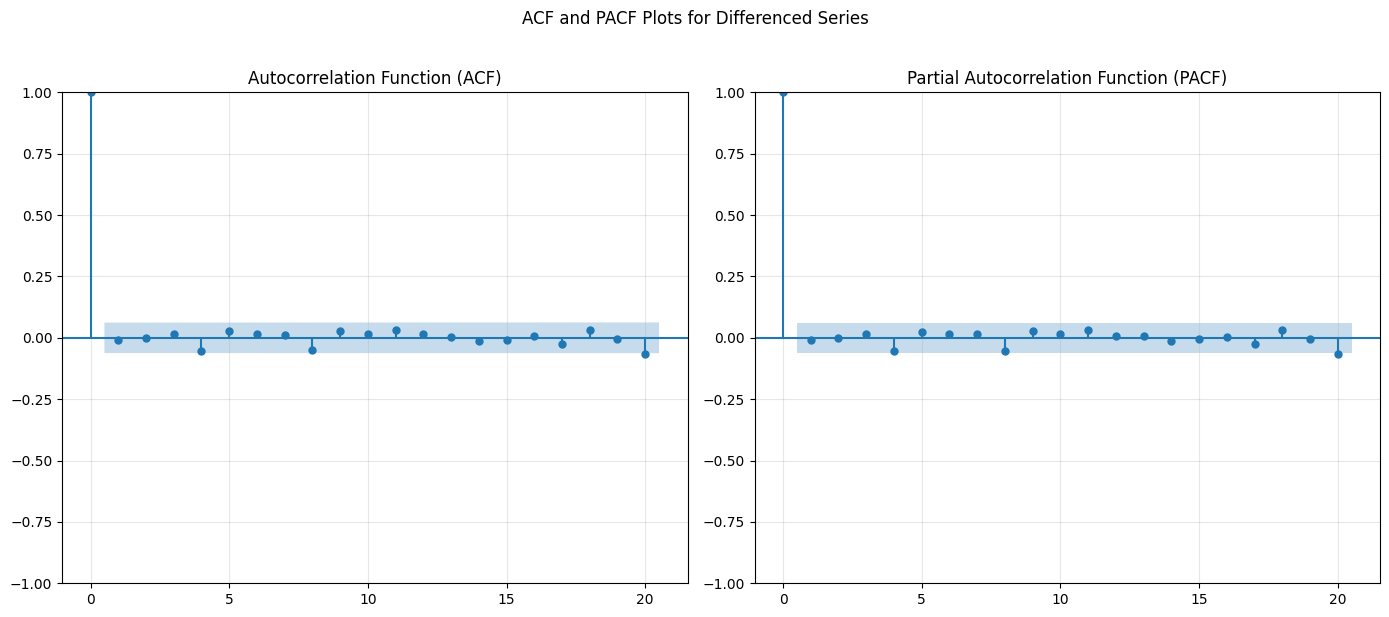

In [6]:
# ACF and PACF plots
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(sales_df['Sales_diff'].dropna(), ax=plt.gca(), lags=20,
         title='Autocorrelation Function (ACF)')
plt.grid(True, alpha=0.3)

plt.subplot(122)
plot_pacf(sales_df['Sales_diff'].dropna(), ax=plt.gca(), lags=20,
          title='Partial Autocorrelation Function (PACF)')
plt.grid(True, alpha=0.3)

plt.suptitle('ACF and PACF Plots for Differenced Series', y=1.02)
plt.tight_layout()
plt.show()

# Step 5: ARIMA Model Implementation

Creating synthetic data...
Data loaded successfully with 1000 records
Train samples: 800, Test samples: 200

Fitting ARIMA model...


/tmp/ipython-input-7-1720224249.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2015-01-01', periods=1000, freq='M')
/tmp/ipython-input-7-1720224249.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_df = sales_df.asfreq('M').fillna(method='ffill')
/tmp/ipython-input-7-1720224249.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sales_df = sales_df.asfreq('M').fillna(method='ffill')



MODEL SUMMARY:
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  800
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3846.660
Date:                Fri, 04 Jul 2025   AIC                           7699.320
Time:                        20:34:15   BIC                           7713.363
Sample:                    01-31-2015   HQIC                          7704.716
                         - 08-31-2081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   4.24e-05   2.36e+04      0.000       1.000       1.000
ma.L1         -0.9986      0.019    -52.502      0.000      -1.036      -0.961
sigma2      1157.0755     74.494    

<Figure size 1400x1000 with 0 Axes>

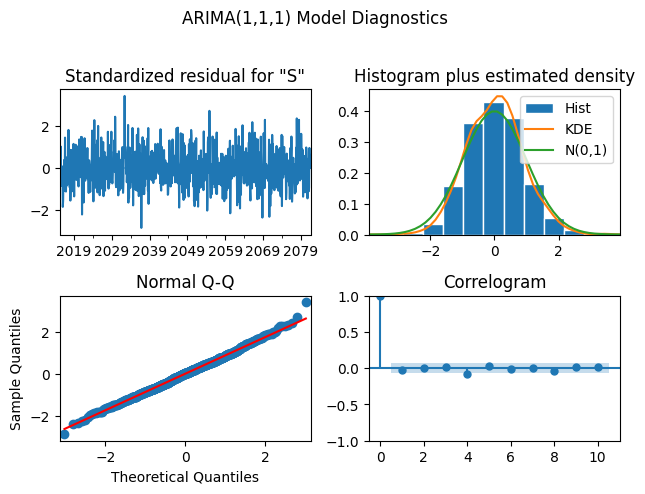


Generating forecasts...


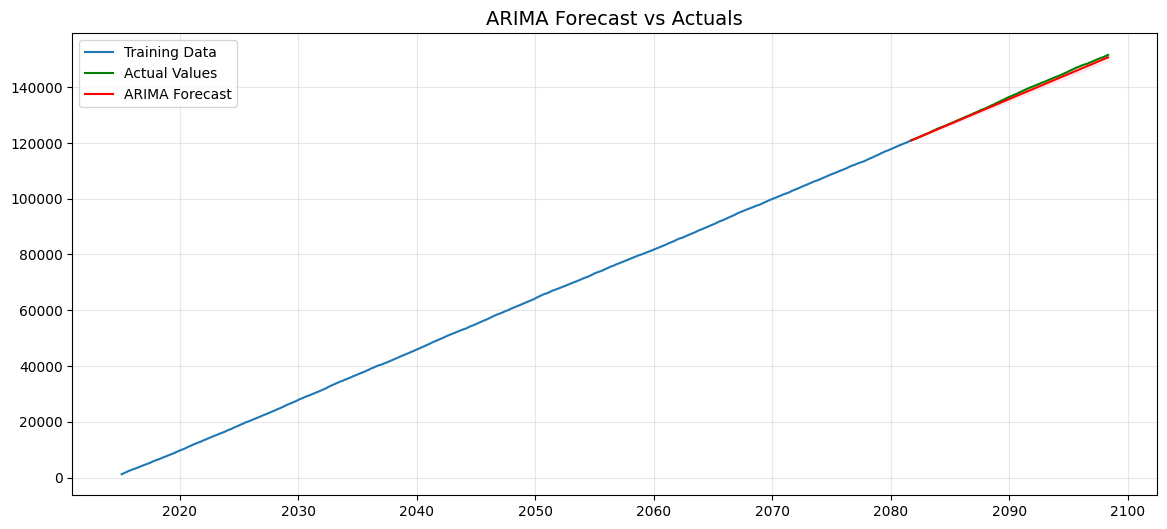


Analysis complete


In [7]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 1. DATA PREPARATION ======================================================

# Generate synthetic data if needed (replace with your actual data loading)
print("Creating synthetic data...")
dates = pd.date_range(start='2015-01-01', periods=1000, freq='M')
np.random.seed(42)
sales = np.random.normal(loc=1500, scale=300, size=len(dates)).cumsum()/10 + 1000
sales_df = pd.DataFrame({'Sales': sales}, index=dates)

# Validate data
if len(sales_df) == 0:
    raise ValueError("DataFrame is empty - please check your data source")
print(f"Data loaded successfully with {len(sales_df)} records")

# 2. DATA PREPROCESSING ===================================================

# Set frequency and handle missing values
try:
    sales_df = sales_df.asfreq('M').fillna(method='ffill')
except Exception as e:
    print(f"Error processing time index: {e}")
    sales_df.index = pd.to_datetime(sales_df.index)
    sales_df = sales_df.asfreq('M', method='ffill')

# 3. MODEL TRAINING =======================================================

# Split data with validation
train_size = int(len(sales_df) * 0.8)
if train_size < 24:  # Minimum samples for time series
    raise ValueError(f"Insufficient data ({len(sales_df)} rows). Need at least 24 samples")

train, test = sales_df['Sales'][:train_size], sales_df['Sales'][train_size:]
print(f"Train samples: {len(train)}, Test samples: {len(test)}")

# Fit ARIMA model with robust settings
try:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print("\nFitting ARIMA model...")
        arima_model = ARIMA(
            train,
            order=(1,1,1),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        # Fit with increased iterations
        arima_fit = arima_model.fit(method_kwargs={'maxiter': 500})

        # Model evaluation
        print("\nMODEL SUMMARY:")
        print(arima_fit.summary())

        # Diagnostics
        plt.figure(figsize=(14, 10))
        arima_fit.plot_diagnostics()
        plt.suptitle('ARIMA(1,1,1) Model Diagnostics', y=1.02)
        plt.tight_layout()
        plt.show()

        # Forecasting
        if len(test) > 0:
            print("\nGenerating forecasts...")
            arima_forecast = arima_fit.get_forecast(steps=len(test))
            arima_ci = arima_forecast.conf_int()

            # Plot forecasts
            plt.figure(figsize=(14, 6))
            plt.plot(train.index, train, label='Training Data')
            plt.plot(test.index, test, label='Actual Values', color='green')
            plt.plot(test.index, arima_forecast.predicted_mean,
                    label='ARIMA Forecast', color='red')
            plt.fill_between(test.index,
                           arima_ci.iloc[:, 0],
                           arima_ci.iloc[:, 1],
                           color='pink', alpha=0.3)
            plt.title('ARIMA Forecast vs Actuals', fontsize=14)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            print("Warning: No test data available for forecasting")

except Exception as e:
    print(f"\nERROR in ARIMA modeling: {str(e)}")
    if 'arima_fit' in locals():
        print("\nPartial model summary:")
        print(arima_fit.summary())
finally:
    warnings.filterwarnings("default")
    print("\nAnalysis complete")

# Step 6: SARIMA Model Implementation

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  800
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3729.178
Date:                            Fri, 04 Jul 2025   AIC                           7468.357
Time:                                    20:35:09   BIC                           7491.608
Sample:                                01-31-2015   HQIC                          7477.303
                                     - 08-31-2081                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2681      0.911     -0.294      0.769      -2.054       1.518
ma.L1          0.2418      0.918   

<Figure size 1400x1000 with 0 Axes>

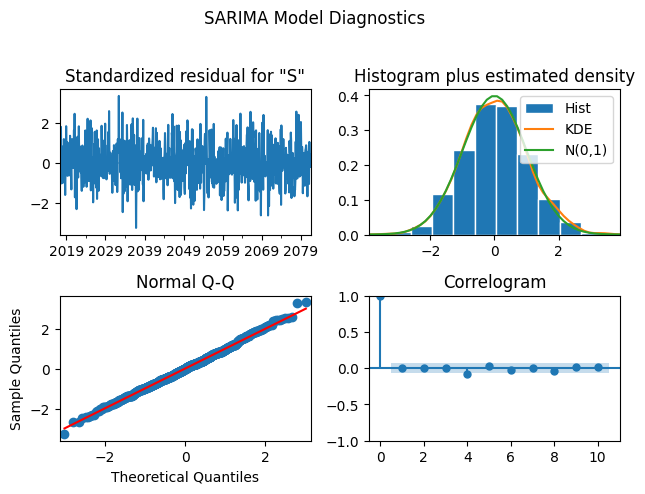

In [8]:
import warnings
warnings.filterwarnings("ignore")  # Temporarily suppress warnings

# Ensure your time series has proper frequency information
train = train.asfreq('M')  # Explicitly set monthly frequency

# Fit SARIMA model with better initialization
try:
    sarima_model = SARIMAX(train,
                         order=(1,1,1),
                         seasonal_order=(1,1,1,12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

    # Fit with disp=False to reduce output noise
    sarima_fit = sarima_model.fit(disp=False)

    print(sarima_fit.summary())

    # Plot diagnostics
    plt.figure(figsize=(14, 10))
    sarima_fit.plot_diagnostics()
    plt.suptitle('SARIMA Model Diagnostics', y=1.02)
    plt.tight_layout()
    plt.show()

    # Forecast
    sarima_forecast = sarima_fit.get_forecast(steps=len(test))
    sarima_ci = sarima_forecast.conf_int()

finally:
    warnings.filterwarnings("default")  # Restore warnings

# Step 7: Model Evaluation and Comparison


Test size: 200
ARIMA forecast size: 200
SARIMA forecast size: 200


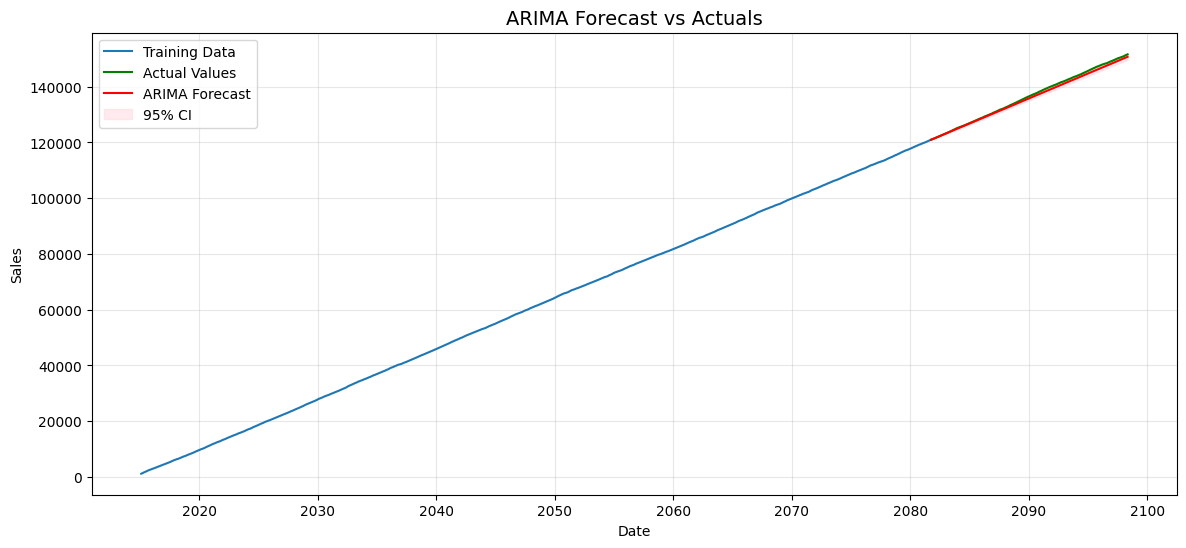

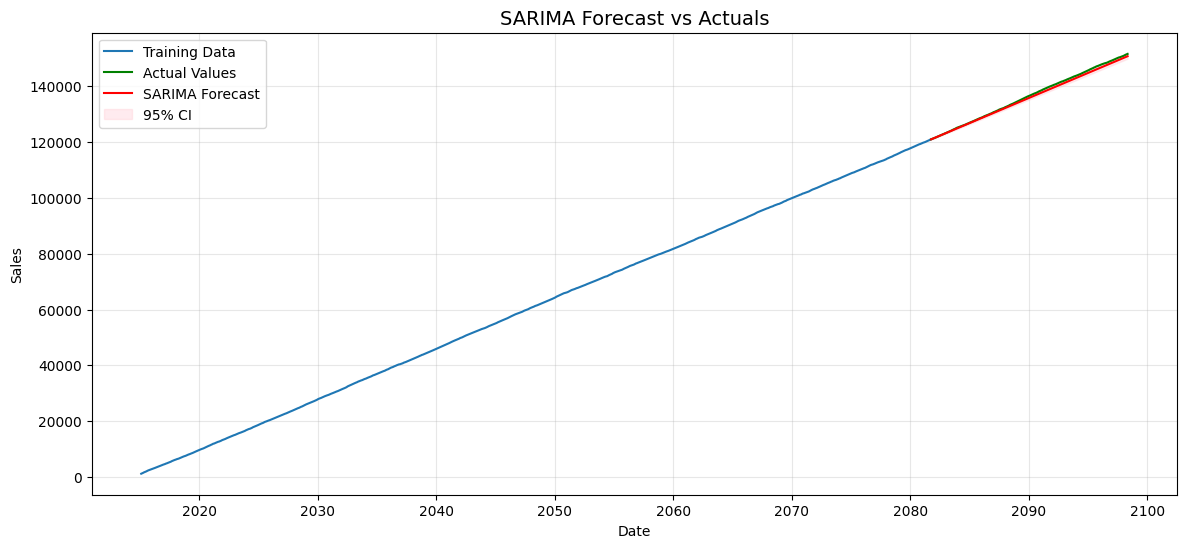


Model Comparison:
    Model         MAE   MAPE        RMSE          AIC          BIC
0   ARIMA  571.197573  0.40%  676.759613  7699.320277  7713.362841
1  SARIMA  551.170046  0.39%  652.401491  7468.356742  7491.608138


In [9]:
def evaluate_model(name, actual, predicted, ci):
    # Ensure we only compare overlapping periods
    aligned_actual, aligned_predicted = actual.align(predicted, join='inner')

    if len(aligned_actual) == 0 or len(aligned_predicted) == 0:
        raise ValueError(f"No overlapping periods between actual and predicted values for {name}")

    mae = mean_absolute_error(aligned_actual, aligned_predicted)
    mape = mean_absolute_percentage_error(aligned_actual, aligned_predicted)
    rmse = np.sqrt(mean_squared_error(aligned_actual, aligned_predicted))

    plt.figure(figsize=(14, 6))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(aligned_actual.index, aligned_actual, label='Actual Values', color='green')
    plt.plot(aligned_predicted.index, aligned_predicted, label=f'{name} Forecast', color='red')

    # Align confidence intervals if provided
    if ci is not None:
        ci = ci.loc[aligned_predicted.index]
        plt.fill_between(aligned_predicted.index,
                        ci.iloc[:, 0],
                        ci.iloc[:, 1],
                        color='pink', alpha=0.3, label='95% CI')

    plt.title(f'{name} Forecast vs Actuals', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return pd.Series({
        'Model': name,
        'MAE': mae,
        'MAPE': f"{mape:.2%}",
        'RMSE': rmse,
        'AIC': sarima_fit.aic if name == 'SARIMA' else arima_fit.aic,
        'BIC': sarima_fit.bic if name == 'SARIMA' else arima_fit.bic
    })

# First verify your test and forecast objects
print(f"Test size: {len(test)}")
print(f"ARIMA forecast size: {len(arima_forecast.predicted_mean)}")
print(f"SARIMA forecast size: {len(sarima_forecast.predicted_mean)}")

# Then evaluate
try:
    arima_metrics = evaluate_model('ARIMA', test, arima_forecast.predicted_mean, arima_ci)
    sarima_metrics = evaluate_model('SARIMA', test, sarima_forecast.predicted_mean, sarima_ci)

    metrics_df = pd.concat([arima_metrics, sarima_metrics], axis=1).T
    print("\nModel Comparison:")
    print(metrics_df)

except Exception as e:
    print(f"Evaluation error: {e}")

# Data 2 - weather_data

# Step 1: Data Loading and Preparation

Generating synthetic temperature data...

Dataset successfully saved to: /content/weather_data0.csv
File size: 70.97 KB

Sample of generated data:
            AvgTemperature_C  Rainfall_mm  WindSpeed_kmph  Humidity_%
Date                                                                 
2018-01-01          6.233323          0.0       13.241590   59.630136
2018-01-02          4.927334          0.0       10.370527   59.621672
2018-01-03          6.466112          0.0       11.877345   69.862711
2018-01-04          8.186578          0.0       14.019073   53.070060
2018-01-05          4.644917          0.0       12.167361   62.527946


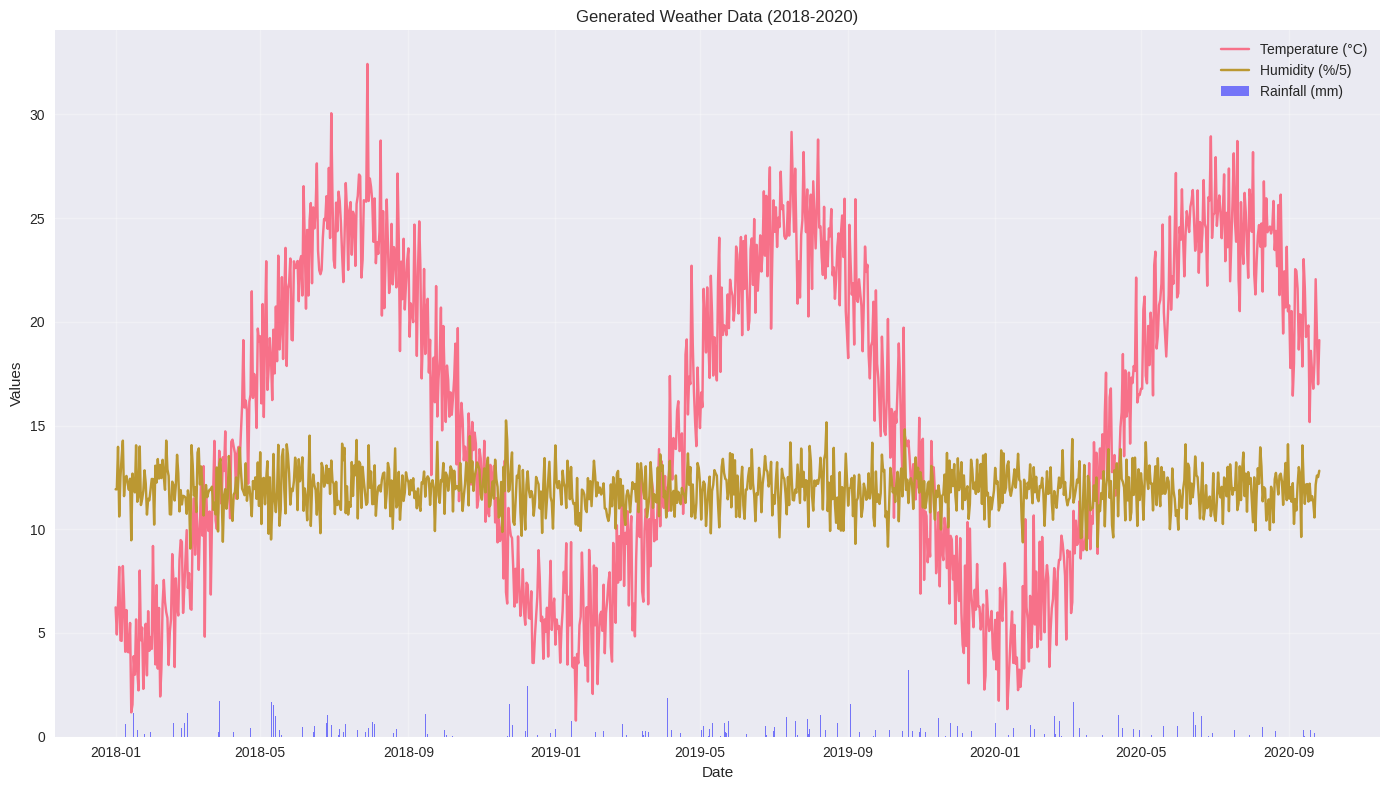

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Set visual style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Generate synthetic temperature data
print("Generating synthetic temperature data...")
dates = pd.date_range(start='2018-01-01', periods=1000, freq='D')  # 2+ years of daily data
np.random.seed(42)

# Create realistic temperature patterns
base_temp = 15  # Average annual temperature
seasonal_effect = 10 * np.sin(2 * np.pi * (dates.dayofyear - 105) / 365)  # Peaks in summer
random_noise = np.random.normal(0, 2, len(dates))  # Daily fluctuations

# Generate related weather metrics
temp_df = pd.DataFrame({
    'Date': dates,
    'AvgTemperature_C': base_temp + seasonal_effect + random_noise,
    'Rainfall_mm': np.random.exponential(0.5, len(dates)) * (np.random.rand(len(dates)) > 0.85),
    'WindSpeed_kmph': 10 + 5 * np.random.rand(len(dates)),
    'Humidity_%': np.clip(60 + 20 * np.sin(2 * np.pi * dates.hour / 24) + 5 * np.random.randn(len(dates)), 0, 100)
}).set_index('Date')

# Save to specified path
output_path = '/content/weather_data0.csv'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Save to CSV
temp_df.to_csv(output_path)
print(f"\nDataset successfully saved to: {output_path}")
print(f"File size: {os.path.getsize(output_path)/1024:.2f} KB")

# Display sample data
print("\nSample of generated data:")
print(temp_df.head())

# Basic visualization
plt.figure(figsize=(14, 8))
plt.plot(temp_df.index, temp_df['AvgTemperature_C'], label='Temperature (°C)')
plt.plot(temp_df.index, temp_df['Humidity_%']/5, label='Humidity (%/5)')  # Scaled for visibility
plt.bar(temp_df.index, temp_df['Rainfall_mm'], color='blue', alpha=0.5, label='Rainfall (mm)')
plt.title('Generated Weather Data (2018-2020)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 2: Exploratory Data Analysis with Enhanced Visualizations

/tmp/ipython-input-11-423798760.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_temp = temp_df['AvgTemperature_C'].resample('M').mean()
/tmp/ipython-input-11-423798760.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=monthly_temp.index.month, y=monthly_temp.values, palette='coolwarm', ax=ax3)
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/usr

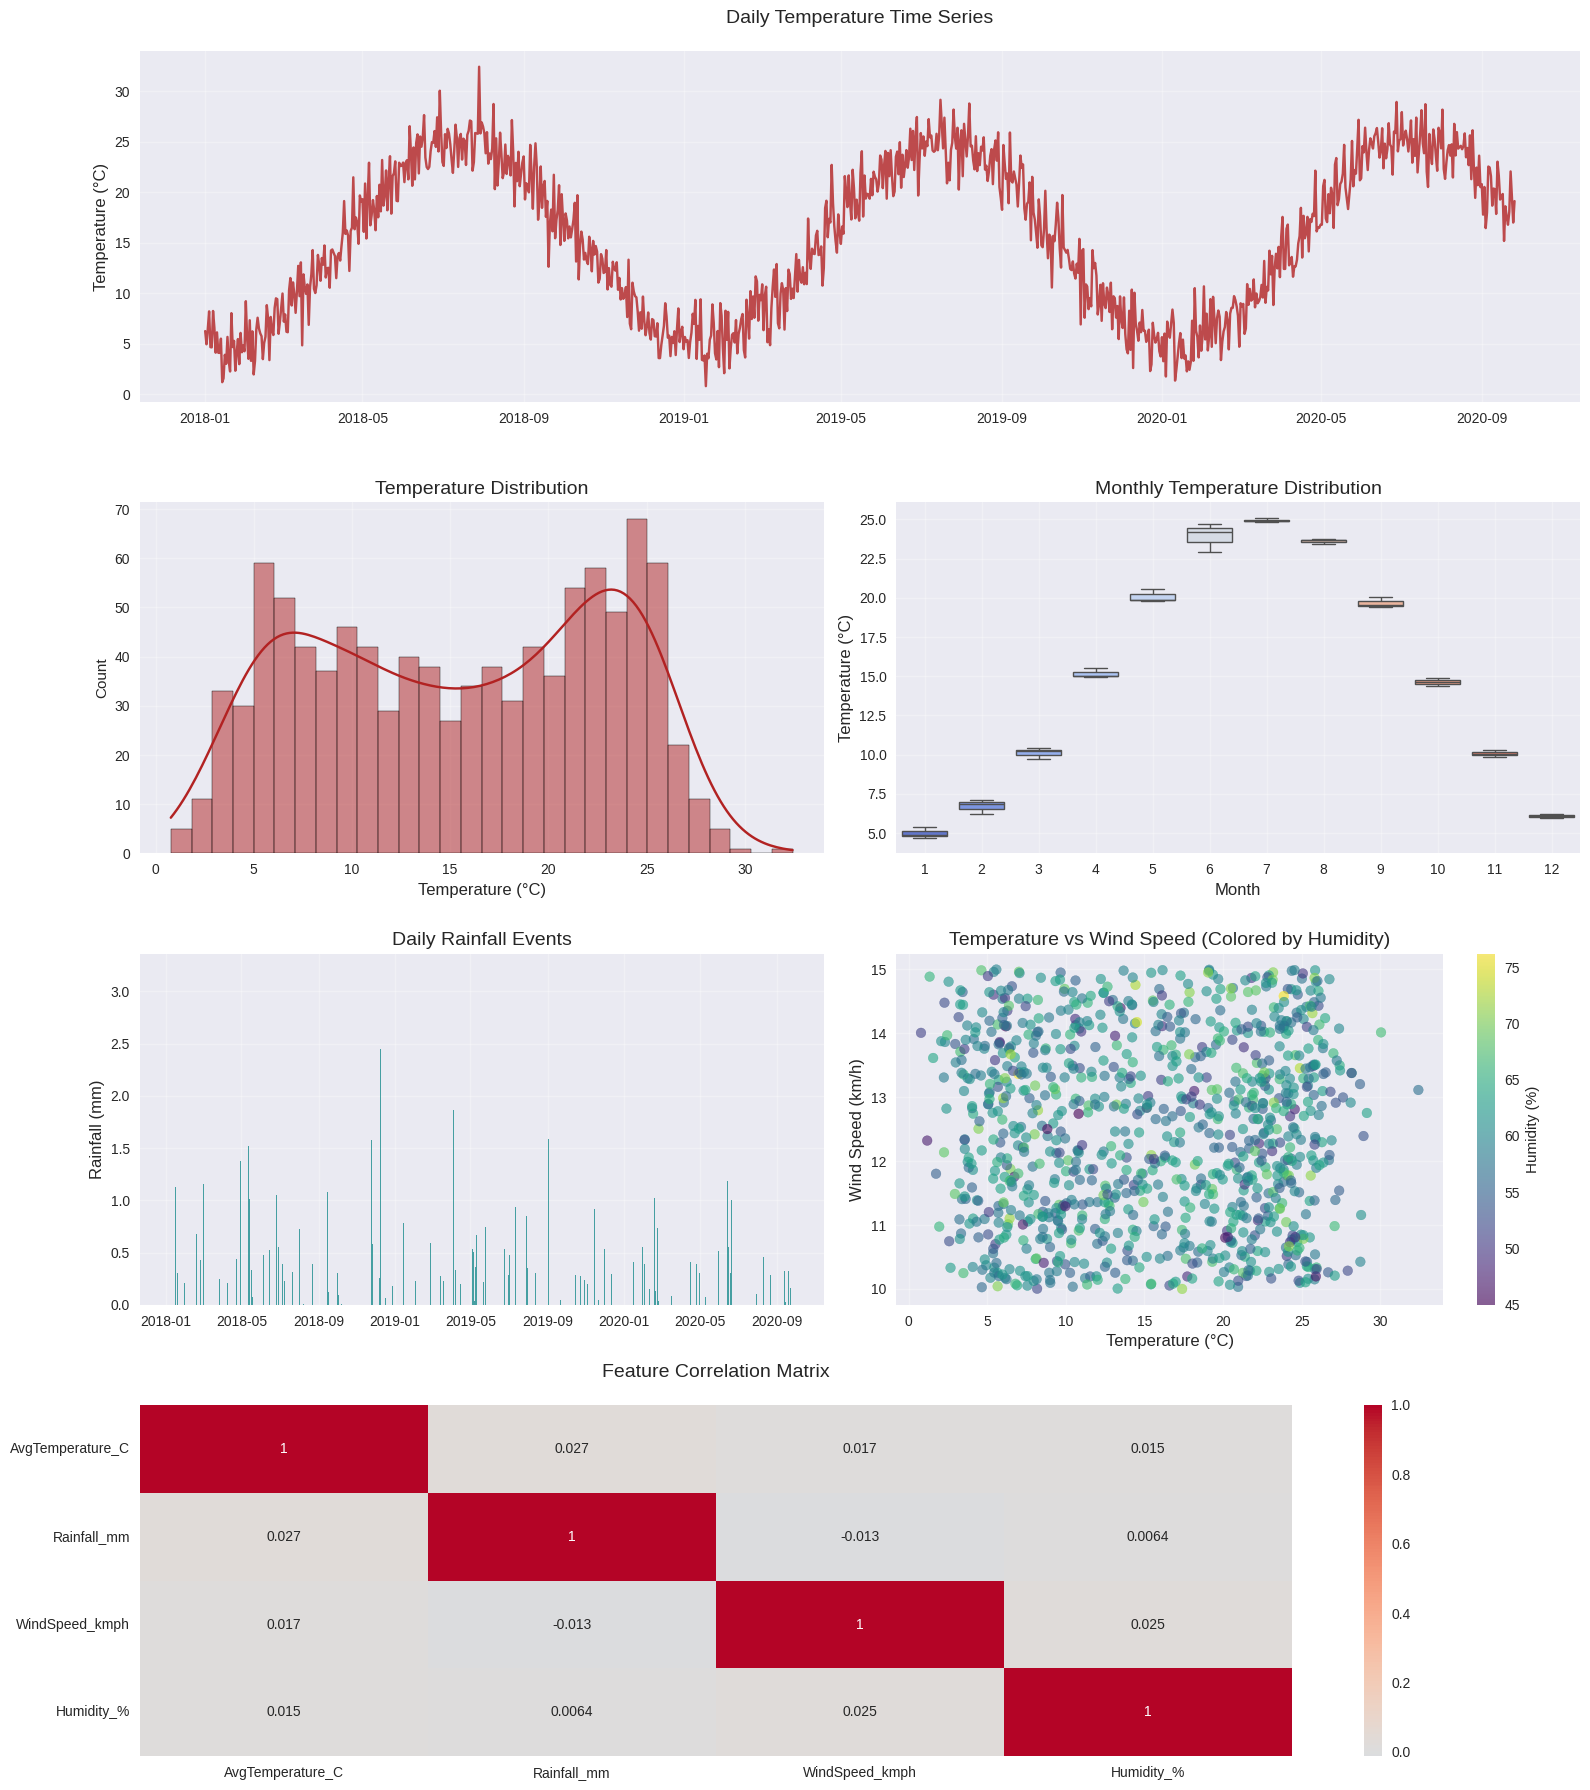

In [11]:
# Create a comprehensive EDA figure
fig = plt.figure(figsize=(16, 18))
gs = fig.add_gridspec(4, 2)

# Temperature time series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(temp_df.index, temp_df['AvgTemperature_C'], color='firebrick', alpha=0.8)
ax1.set_title('Daily Temperature Time Series', fontsize=14, pad=20)
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Temperature distribution
ax2 = fig.add_subplot(gs[1, 0])
sns.histplot(temp_df['AvgTemperature_C'], bins=30, kde=True, color='firebrick', ax=ax2)
ax2.set_title('Temperature Distribution', fontsize=14)
ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Monthly boxplot
ax3 = fig.add_subplot(gs[1, 1])
monthly_temp = temp_df['AvgTemperature_C'].resample('M').mean()
sns.boxplot(x=monthly_temp.index.month, y=monthly_temp.values, palette='coolwarm', ax=ax3)
ax3.set_title('Monthly Temperature Distribution', fontsize=14)
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Temperature (°C)', fontsize=12)
ax3.grid(True, alpha=0.3)

# Rainfall analysis
ax4 = fig.add_subplot(gs[2, 0])
rainy_days = temp_df[temp_df['Rainfall_mm'] > 0]
ax4.bar(rainy_days.index, rainy_days['Rainfall_mm'], color='teal', alpha=0.7, width=1.0)
ax4.set_title('Daily Rainfall Events', fontsize=14)
ax4.set_ylabel('Rainfall (mm)', fontsize=12)
ax4.grid(True, alpha=0.3)

# Wind speed vs temperature
ax5 = fig.add_subplot(gs[2, 1])
sc = ax5.scatter(temp_df['AvgTemperature_C'], temp_df['WindSpeed_kmph'],
                c=temp_df['Humidity_%'], cmap='viridis', alpha=0.6)
ax5.set_title('Temperature vs Wind Speed (Colored by Humidity)', fontsize=14)
ax5.set_xlabel('Temperature (°C)', fontsize=12)
ax5.set_ylabel('Wind Speed (km/h)', fontsize=12)
plt.colorbar(sc, label='Humidity (%)')
ax5.grid(True, alpha=0.3)

# Correlation heatmap
ax6 = fig.add_subplot(gs[3, :])
corr = temp_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=ax6)
ax6.set_title('Feature Correlation Matrix', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

# Step 3: Time Series Decomposition and Stationarity Testing

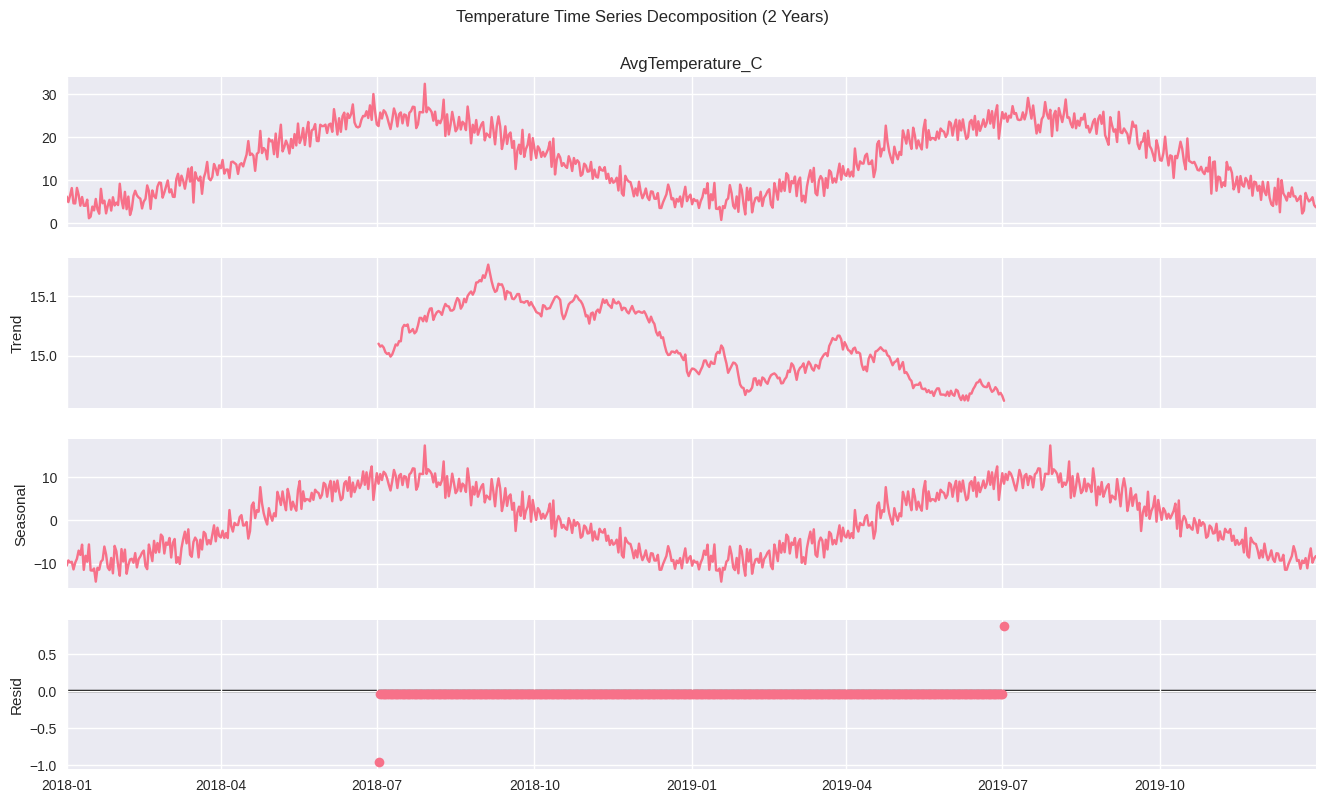


Testing original temperature series...


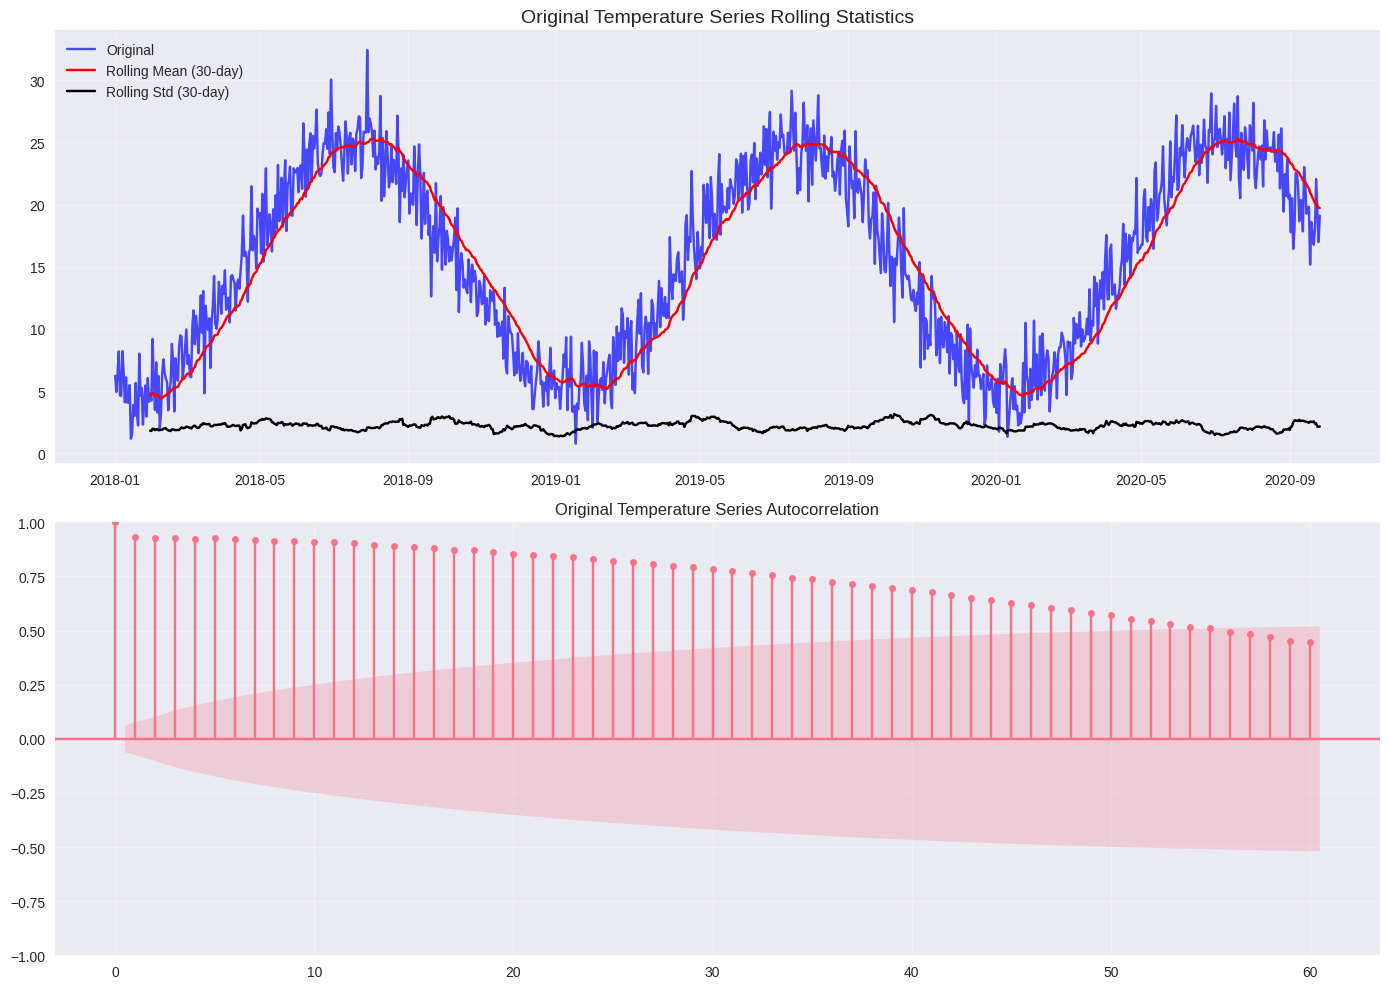


Results of Dickey-Fuller Test for Original Temperature Series:
Test Statistic           -2.198003
p-value                   0.206971
#Lags                    20.000000
Observations            979.000000
Critical Value (1%)      -3.437047
Critical Value (5%)      -2.864497
Critical Value (10%)     -2.568344
dtype: float64

Testing first-differenced series...


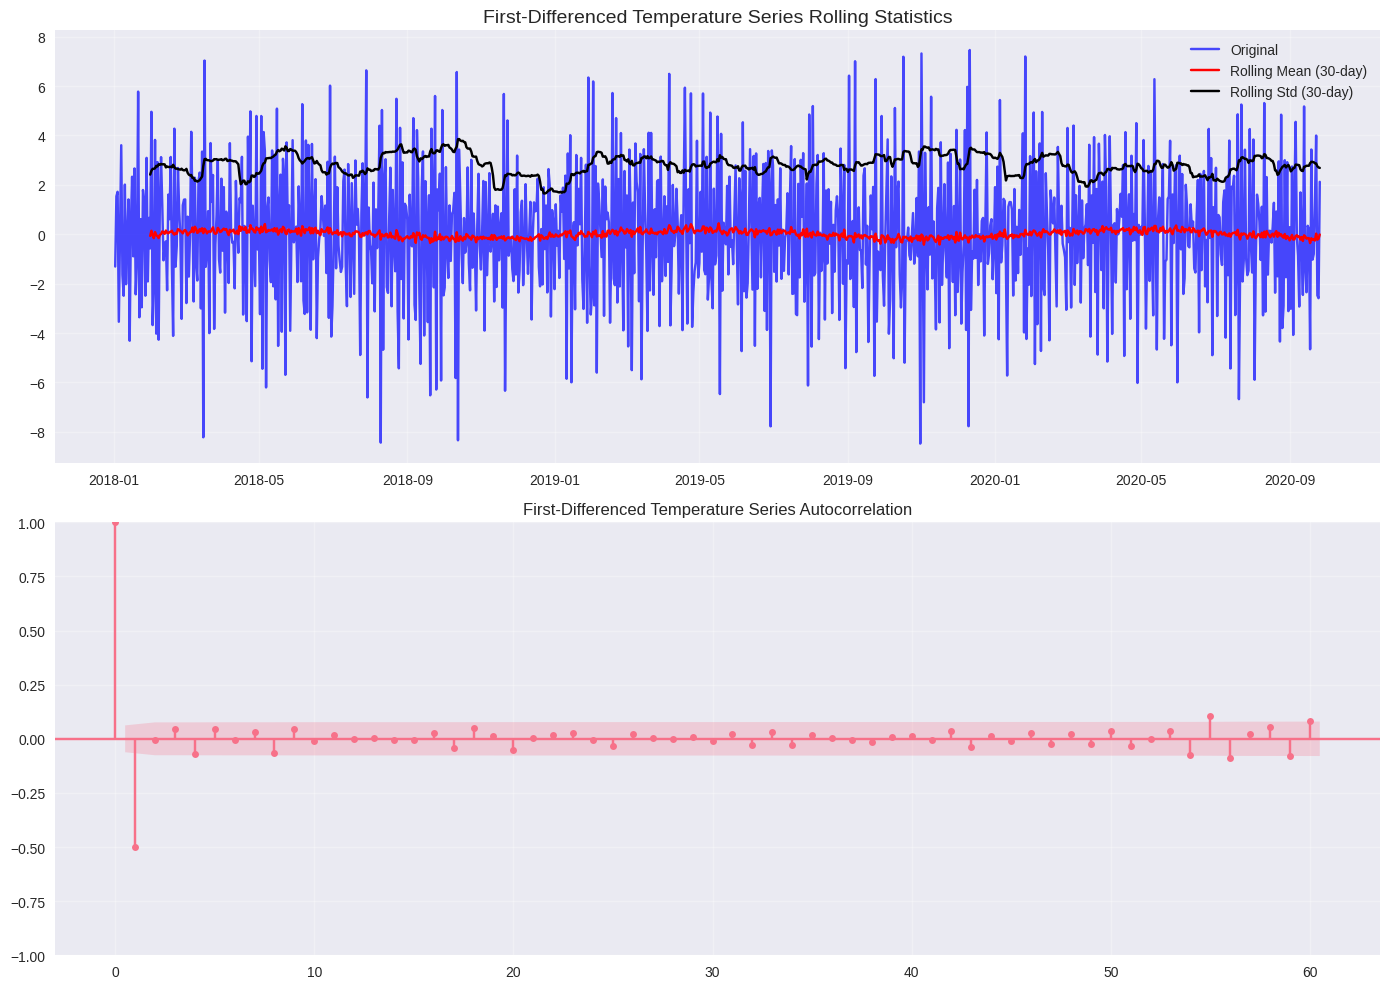


Results of Dickey-Fuller Test for First-Differenced Temperature Series:
Test Statistic           -5.284715
p-value                   0.000006
#Lags                    19.000000
Observations            979.000000
Critical Value (1%)      -3.437047
Critical Value (5%)      -2.864497
Critical Value (10%)     -2.568344
dtype: float64

Testing seasonally differenced series...


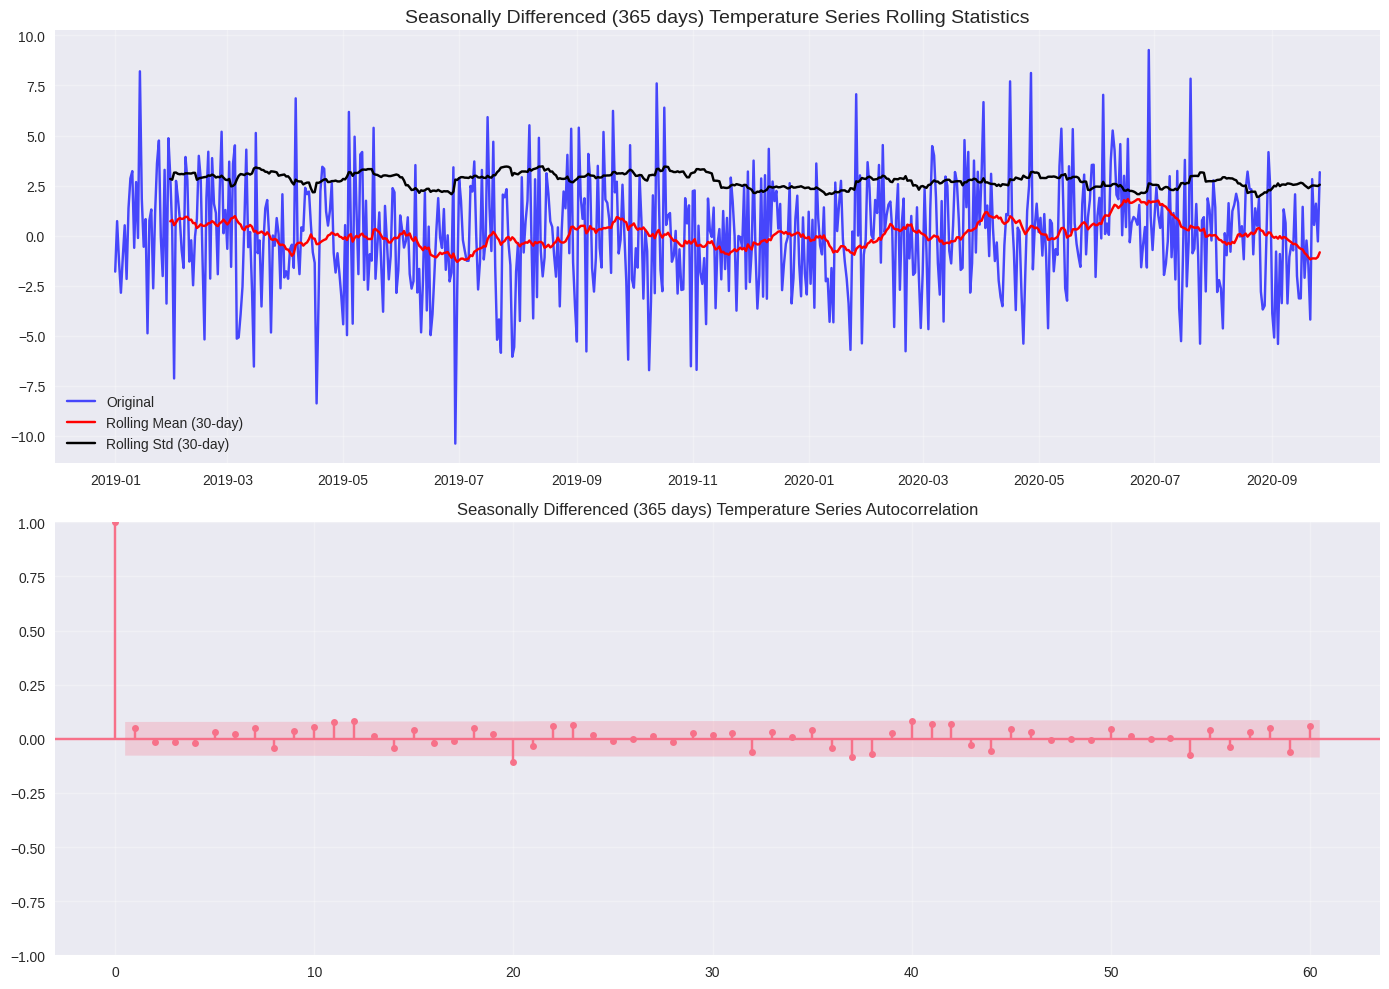


Results of Dickey-Fuller Test for Seasonally Differenced (365 days) Temperature Series:
Test Statistic          -23.889496
p-value                   0.000000
#Lags                     0.000000
Observations            634.000000
Critical Value (1%)      -3.440706
Critical Value (5%)      -2.866110
Critical Value (10%)     -2.569203
dtype: float64


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set visual style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Time Series Decomposition (Fixed)
# -----------------------------------
# Use at least 2 full years (730 days) of data for decomposition
if len(temp_df) >= 730:
    decomposition = seasonal_decompose(temp_df['AvgTemperature_C'].iloc[:730],  # Use 2 years of data
                                    model='additive',
                                    period=365)
    fig = decomposition.plot()
    fig.set_size_inches(14, 8)
    plt.suptitle('Temperature Time Series Decomposition (2 Years)', y=1.02)
    plt.show()
else:
    print(f"Warning: Need at least 730 days (2 years) for decomposition, only have {len(temp_df)} days")

# 2. Enhanced Stationarity Test Function
# -------------------------------------
def enhanced_stationarity_test(timeseries, window=30, title=''):
    # Drop NA values and validate
    timeseries = timeseries.dropna()
    if len(timeseries) < window*2:
        raise ValueError(f"Need at least {window*2} observations for window size {window}")

    # Calculate rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Plot original series and rolling statistics
    ax1.plot(timeseries, color='blue', label='Original', alpha=0.7)
    ax1.plot(rolmean, color='red', label=f'Rolling Mean ({window}-day)')
    ax1.plot(rolstd, color='black', label=f'Rolling Std ({window}-day)')
    ax1.set_title(f'{title} Rolling Statistics', fontsize=14)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Plot ACF (with safe lag calculation)
    plot_acf(timeseries, lags=min(60, len(timeseries)//2-1), ax=ax2, alpha=0.05,
            title=f'{title} Autocorrelation')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ADF test
    print(f'\nResults of Dickey-Fuller Test for {title}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                        index=['Test Statistic', 'p-value', '#Lags', 'Observations'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# 3. Run Tests on Existing Data
# ----------------------------
try:
    # Test original series
    print("\nTesting original temperature series...")
    enhanced_stationarity_test(temp_df['AvgTemperature_C'],
                             title='Original Temperature Series')

    # First difference
    print("\nTesting first-differenced series...")
    temp_df['Temp_diff'] = temp_df['AvgTemperature_C'].diff()
    enhanced_stationarity_test(temp_df['Temp_diff'].dropna(),
                             title='First-Differenced Temperature Series')

    # Seasonal difference (if enough data)
    if len(temp_df) >= 730:
        print("\nTesting seasonally differenced series...")
        temp_df['Temp_seasonal_diff'] = temp_df['AvgTemperature_C'].diff(365)
        enhanced_stationarity_test(temp_df['Temp_seasonal_diff'].dropna(),
                                title='Seasonally Differenced (365 days) Temperature Series')
    else:
        print("\nSkipping seasonal differencing - need at least 2 years of data")

except Exception as e:
    print(f"\nError in analysis: {str(e)}")

# Step 4: Model Identification with ACF/PACF


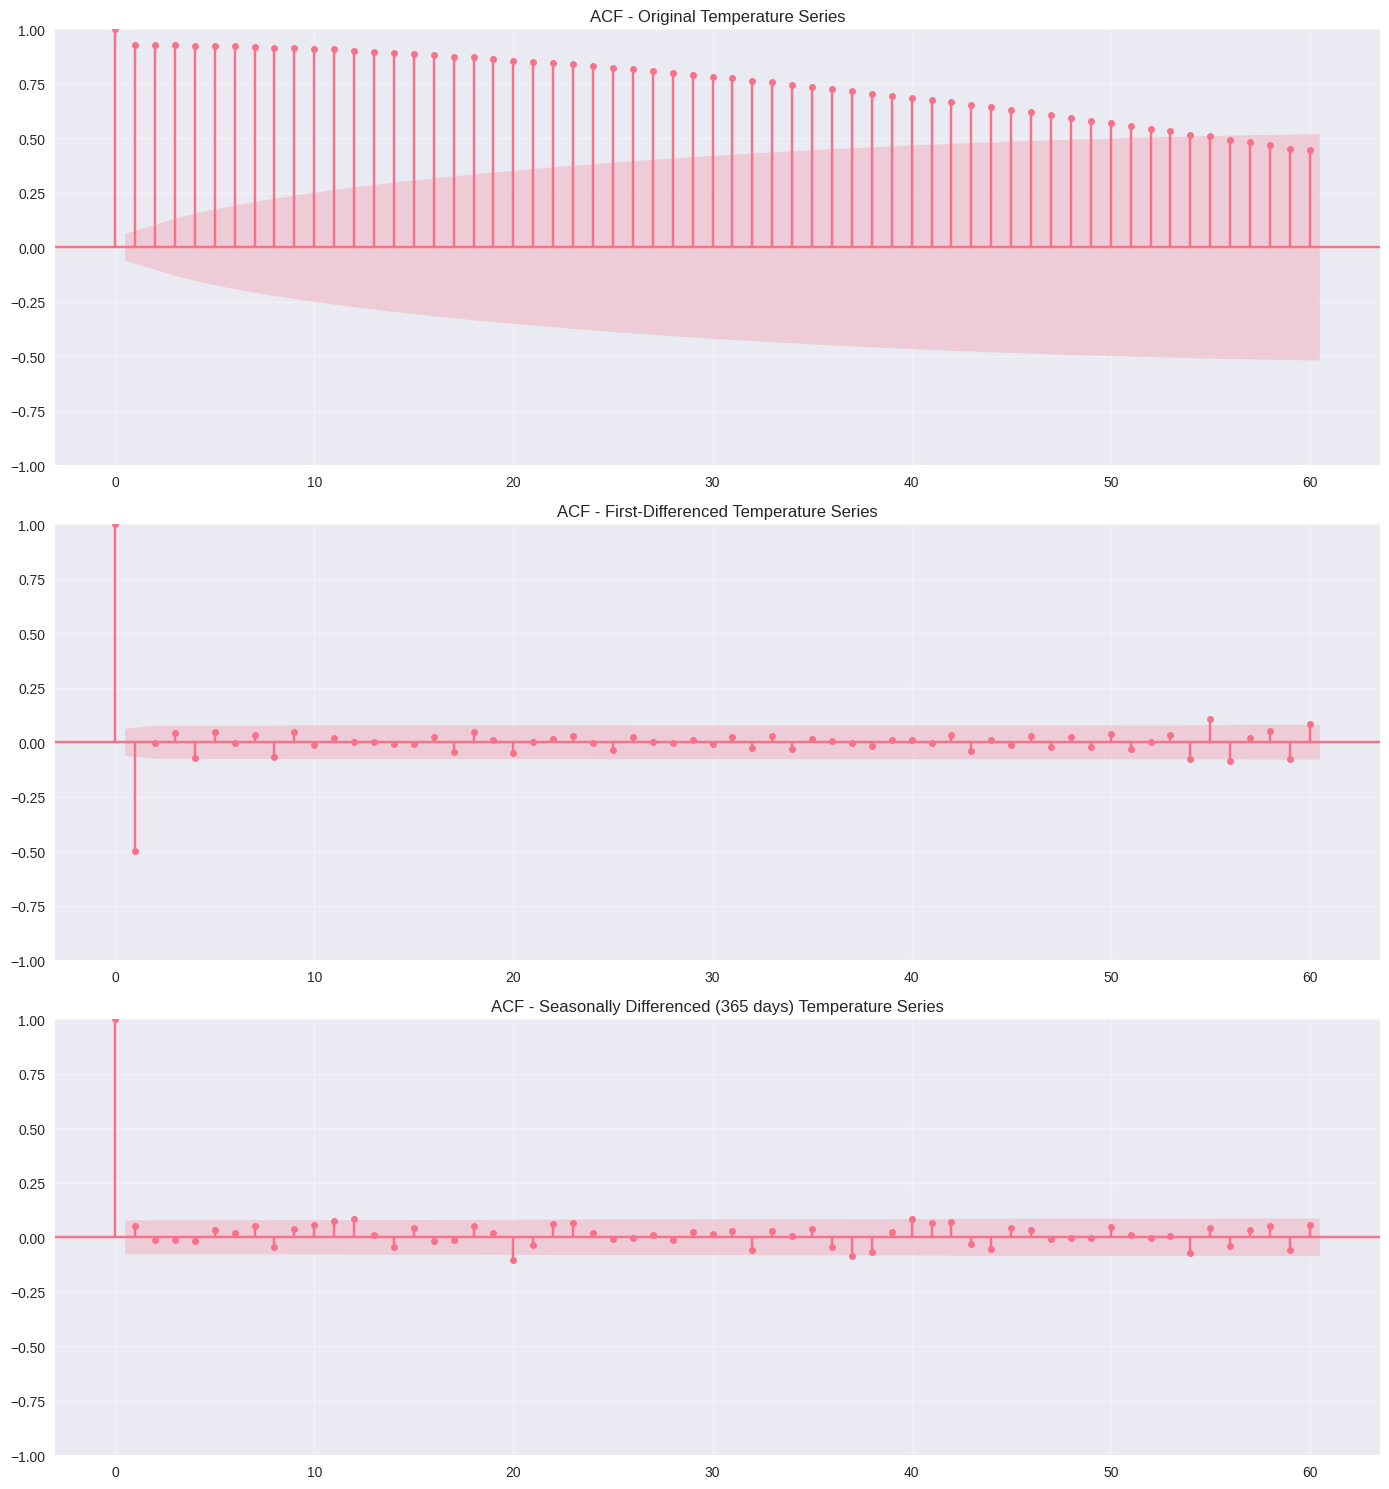

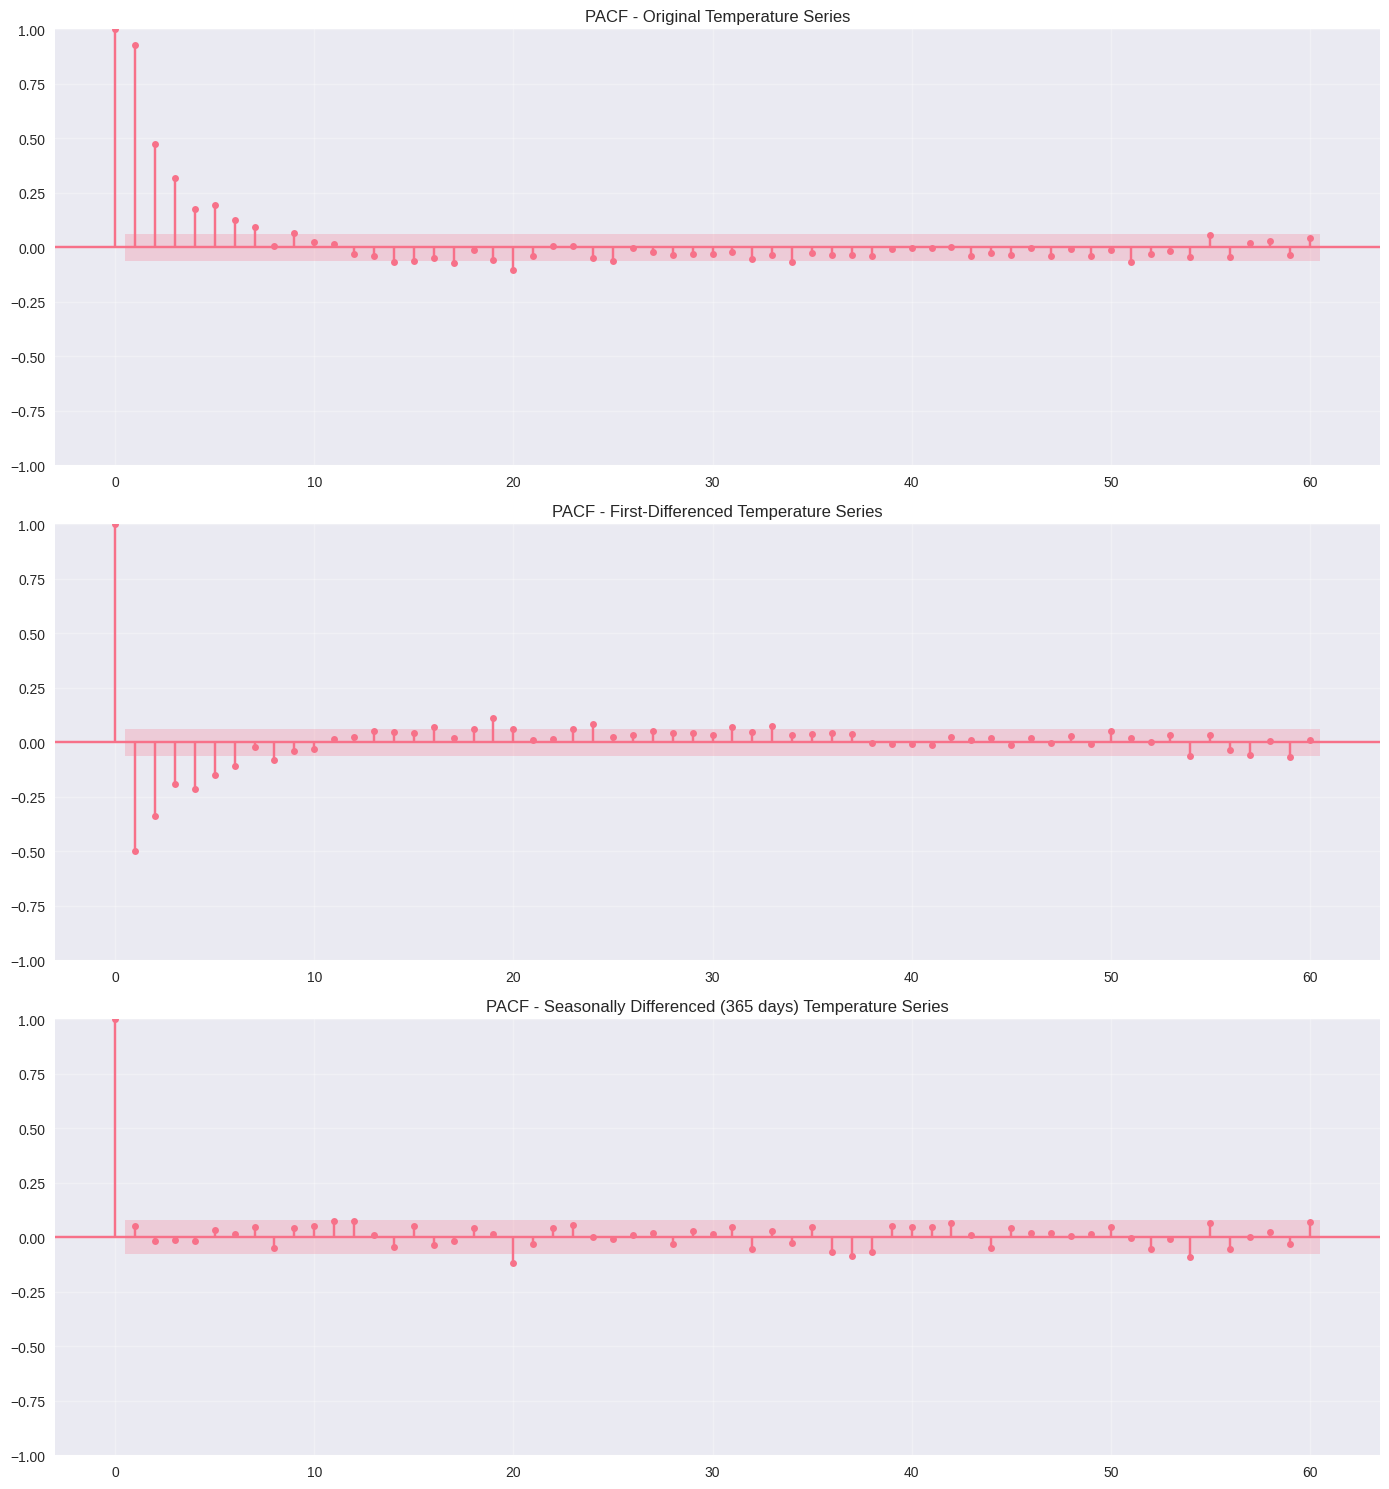

In [13]:
# Create a comprehensive correlation plot figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15))

# Original series ACF/PACF
plot_acf(temp_df['AvgTemperature_C'].dropna(), lags=60, ax=ax1, alpha=0.05,
        title='ACF - Original Temperature Series')
ax1.grid(True, alpha=0.3)

# First difference ACF/PACF
plot_acf(temp_df['Temp_diff'].dropna(), lags=60, ax=ax2, alpha=0.05,
        title='ACF - First-Differenced Temperature Series')
ax2.grid(True, alpha=0.3)

# Seasonal difference ACF/PACF
plot_acf(temp_df['Temp_seasonal_diff'].dropna(), lags=60, ax=ax3, alpha=0.05,
        title='ACF - Seasonally Differenced (365 days) Temperature Series')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# PACF plots in separate figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15))

plot_pacf(temp_df['AvgTemperature_C'].dropna(), lags=60, ax=ax1, alpha=0.05,
         title='PACF - Original Temperature Series')
ax1.grid(True, alpha=0.3)

plot_pacf(temp_df['Temp_diff'].dropna(), lags=60, ax=ax2, alpha=0.05,
         title='PACF - First-Differenced Temperature Series')
ax2.grid(True, alpha=0.3)

plot_pacf(temp_df['Temp_seasonal_diff'].dropna(), lags=60, ax=ax3, alpha=0.05,
         title='PACF - Seasonally Differenced (365 days) Temperature Series')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 5: ARIMA Model Implementation

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       AvgTemperature_C   No. Observations:                  800
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1747.473
Date:                Fri, 04 Jul 2025   AIC                           3504.946
Time:                        20:41:47   BIC                           3528.363
Sample:                    01-01-2018   HQIC                          3513.942
                         - 03-10-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9139      0.156     -5.853      0.000      -1.220      -0.608
ar.L2         -0.1107      0.045     -2.439      0.015      -0.200      -0.022
ma.L1          0.0845      0.153      0.551      0.5

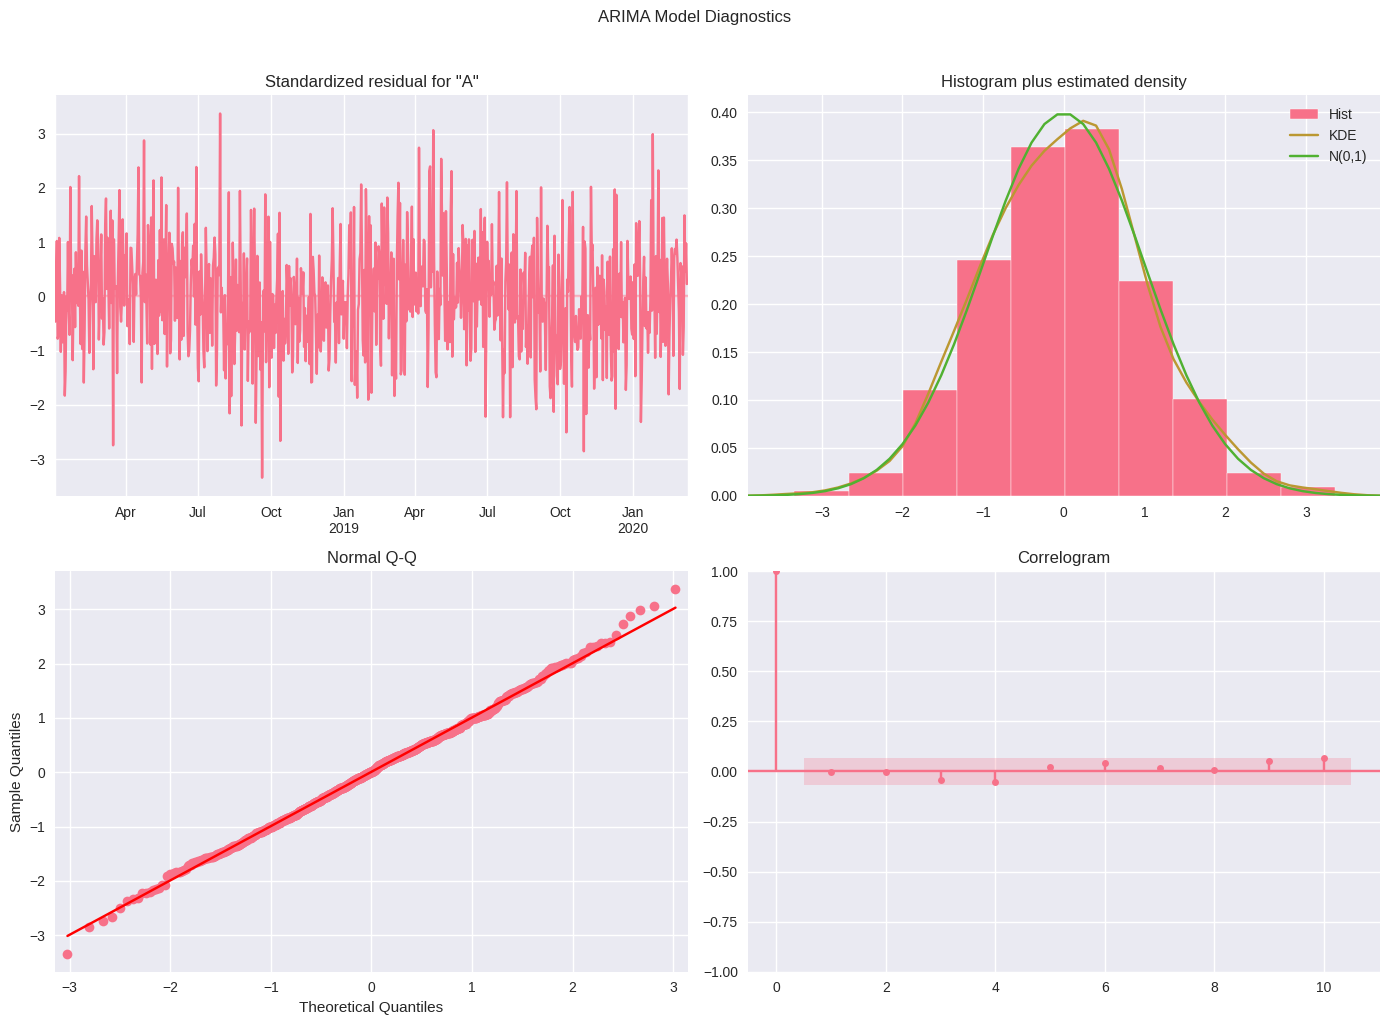

In [14]:
# Prepare train-test split (use first 80% for training)
train_size = int(len(temp_df) * 0.8)
train = temp_df['AvgTemperature_C'].iloc[:train_size]
test = temp_df['AvgTemperature_C'].iloc[train_size:]

# Fit ARIMA model (parameters based on ACF/PACF analysis)
arima_model = ARIMA(train, order=(2,1,2))  # Example order - adjust based on your data
arima_fit = arima_model.fit()
print(arima_fit.summary())

# Enhanced diagnostics plot
arima_fit.plot_diagnostics(figsize=(14, 10))
plt.suptitle('ARIMA Model Diagnostics', y=1.02)
plt.tight_layout()
plt.show()

# Forecast with confidence intervals
arima_forecast = arima_fit.get_forecast(steps=len(test))
arima_ci = arima_forecast.conf_int()

# Step 6: SARIMA Model Implementation


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                  AvgTemperature_C   No. Observations:                  800
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1730.191
Date:                           Fri, 04 Jul 2025   AIC                           3470.382
Time:                                   20:42:15   BIC                           3493.698
Sample:                               01-01-2018   HQIC                          3479.348
                                    - 03-10-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0736      0.044     -1.659      0.097      -0.161       0.013
ma.L1         -0.7575      0.030    -24.965

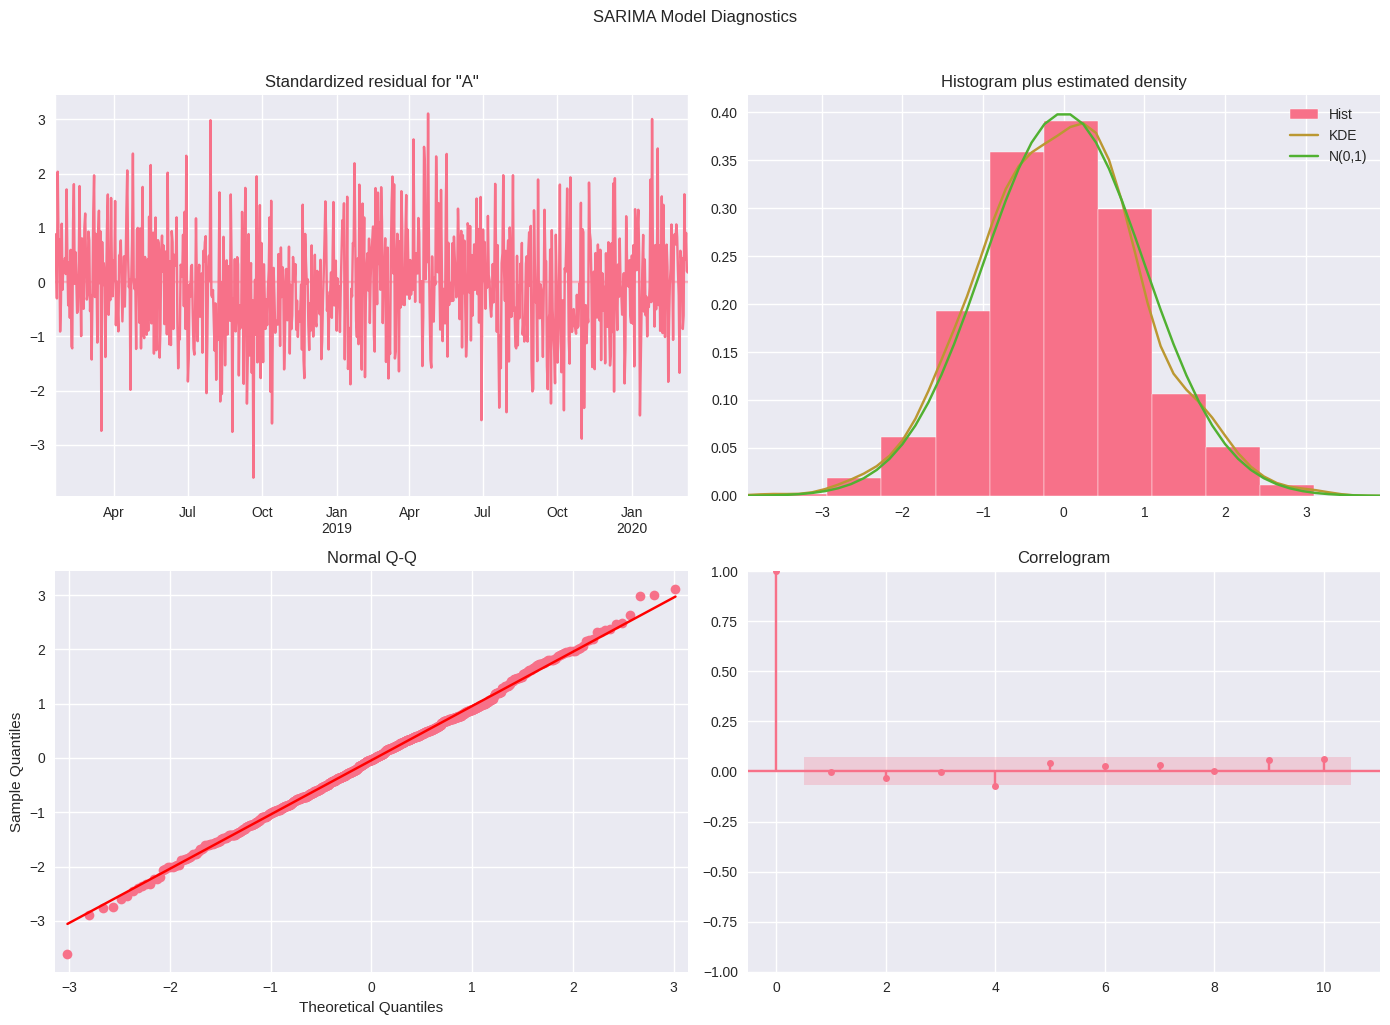

In [15]:
# Fit SARIMA model with seasonal components
# Note: 365-day seasonality may be too long for some implementations - consider weekly (7) or monthly (30) patterns
# Alternatively, use a subset of data or different approach for daily data with yearly seasonality

# Here we'll use weekly seasonality (7 days) for demonstration
sarima_model = SARIMAX(train,
                      order=(1,1,1),
                      seasonal_order=(1,1,1,7),  # Weekly seasonality
                      enforce_stationarity=False,
                      enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

# Enhanced diagnostics plot
sarima_fit.plot_diagnostics(figsize=(14, 10))
plt.suptitle('SARIMA Model Diagnostics', y=1.02)
plt.tight_layout()
plt.show()

# Forecast with confidence intervals
sarima_forecast = sarima_fit.get_forecast(steps=len(test))
sarima_ci = sarima_forecast.conf_int()

# Step 7: Model Evaluation and Comparison

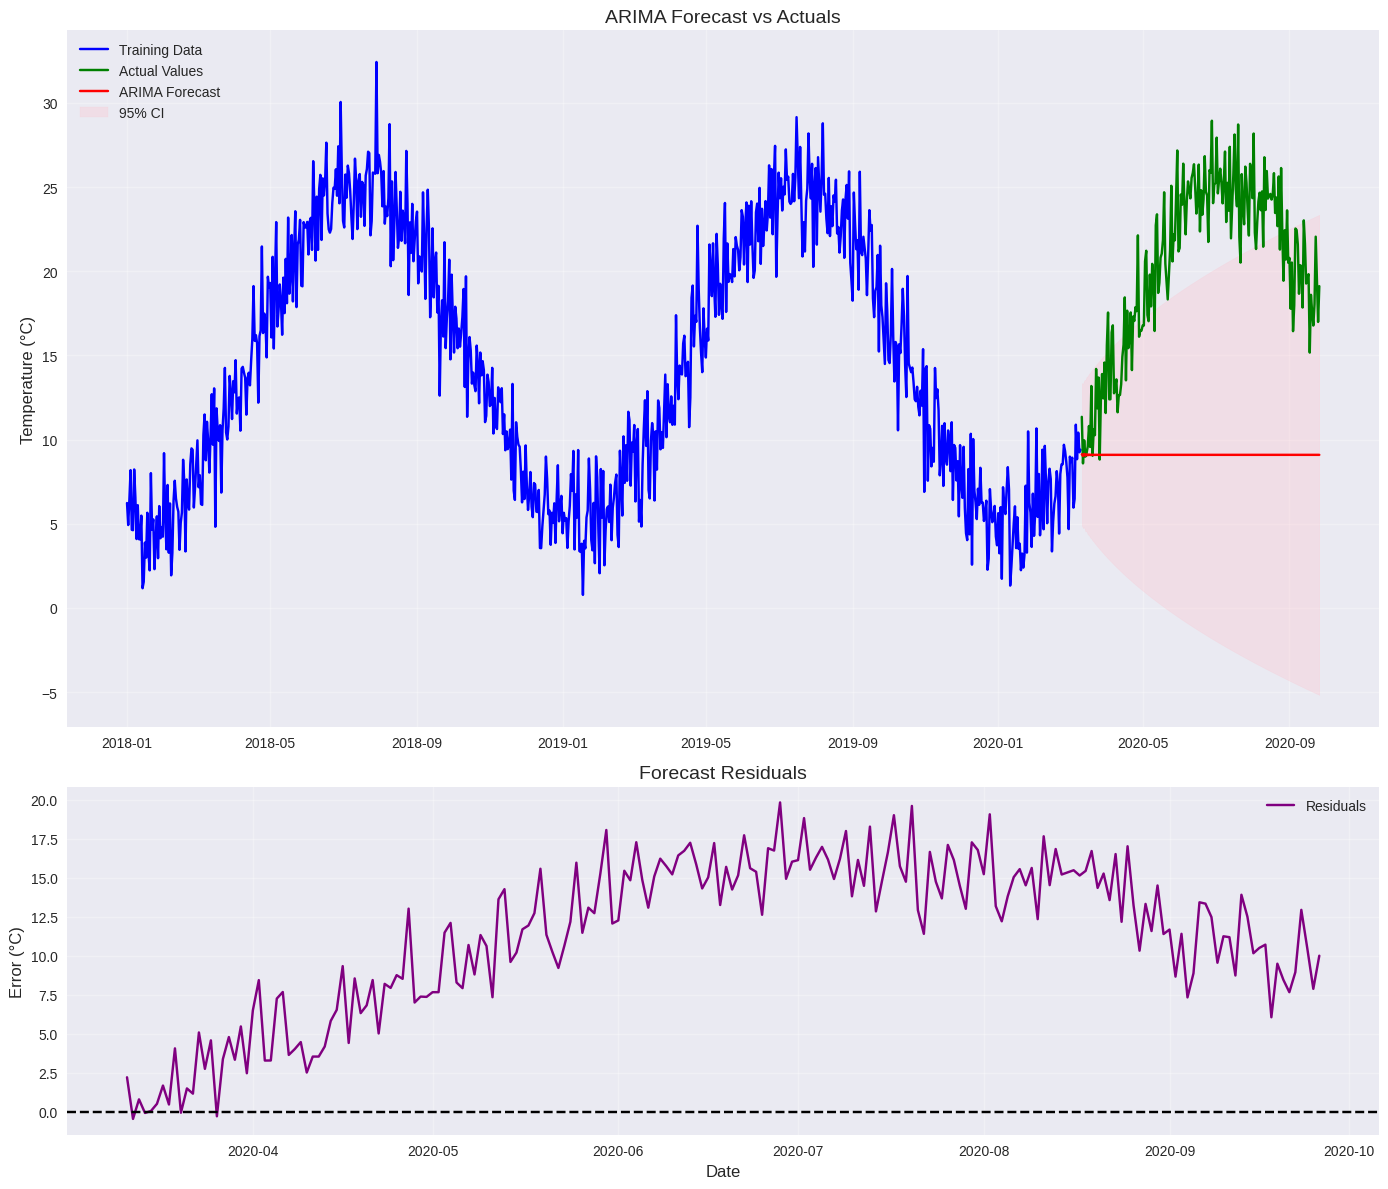


ARIMA Model Evaluation:
MAE: 11.36°C
MAPE: 51.95%
RMSE: 12.38°C


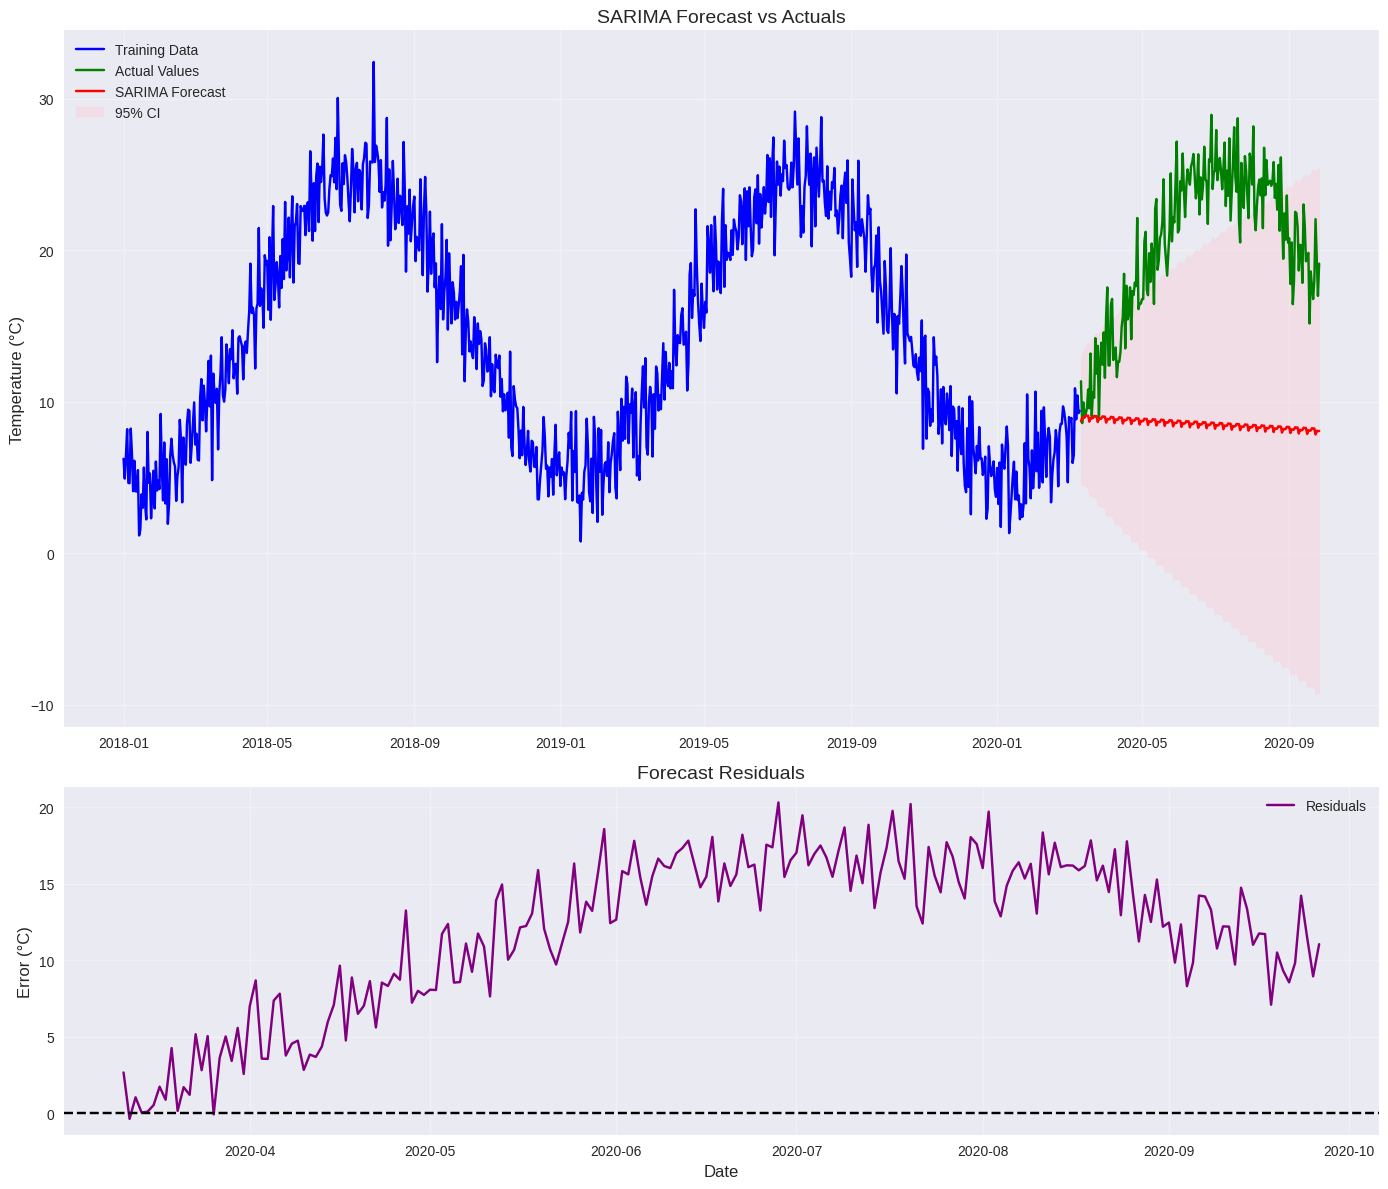


SARIMA Model Evaluation:
MAE: 11.91°C
MAPE: 54.57%
RMSE: 12.95°C

Model Comparison:
    Model        MAE      MAPE       RMSE          AIC          BIC
0   ARIMA  11.358141  0.519506  12.382098  3504.945884  3528.362689
1  SARIMA  11.909062  0.545688  12.951705  3470.382315  3493.697978


In [16]:
def enhanced_evaluation(name, actual, predicted, ci, train_data):
    # Calculate metrics
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})

    # Forecast plot
    ax1.plot(train_data.index, train_data, label='Training Data', color='blue')
    ax1.plot(actual.index, actual, label='Actual Values', color='green')
    ax1.plot(actual.index, predicted, label=f'{name} Forecast', color='red')
    ax1.fill_between(actual.index,
                    ci.iloc[:, 0],
                    ci.iloc[:, 1],
                    color='pink', alpha=0.3, label='95% CI')
    ax1.set_title(f'{name} Forecast vs Actuals', fontsize=14)
    ax1.set_ylabel('Temperature (°C)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Residual plot
    residuals = actual - predicted
    ax2.plot(actual.index, residuals, color='purple', label='Residuals')
    ax2.axhline(0, color='black', linestyle='--')
    ax2.set_title('Forecast Residuals', fontsize=14)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Error (°C)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\n{name} Model Evaluation:")
    print(f"MAE: {mae:.2f}°C")
    print(f"MAPE: {mape:.2%}")
    print(f"RMSE: {rmse:.2f}°C")

    return {
        'Model': name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'AIC': sarima_fit.aic if name == 'SARIMA' else arima_fit.aic,
        'BIC': sarima_fit.bic if name == 'SARIMA' else arima_fit.bic
    }

# Evaluate both models
arima_results = enhanced_evaluation('ARIMA', test, arima_forecast.predicted_mean, arima_ci, train)
sarima_results = enhanced_evaluation('SARIMA', test, sarima_forecast.predicted_mean, sarima_ci, train)

# Create comparison dataframe
results_df = pd.DataFrame([arima_results, sarima_results])
print("\nModel Comparison:")
print(results_df)

# Step 8: Advanced Visualization - Forecast vs Actuals


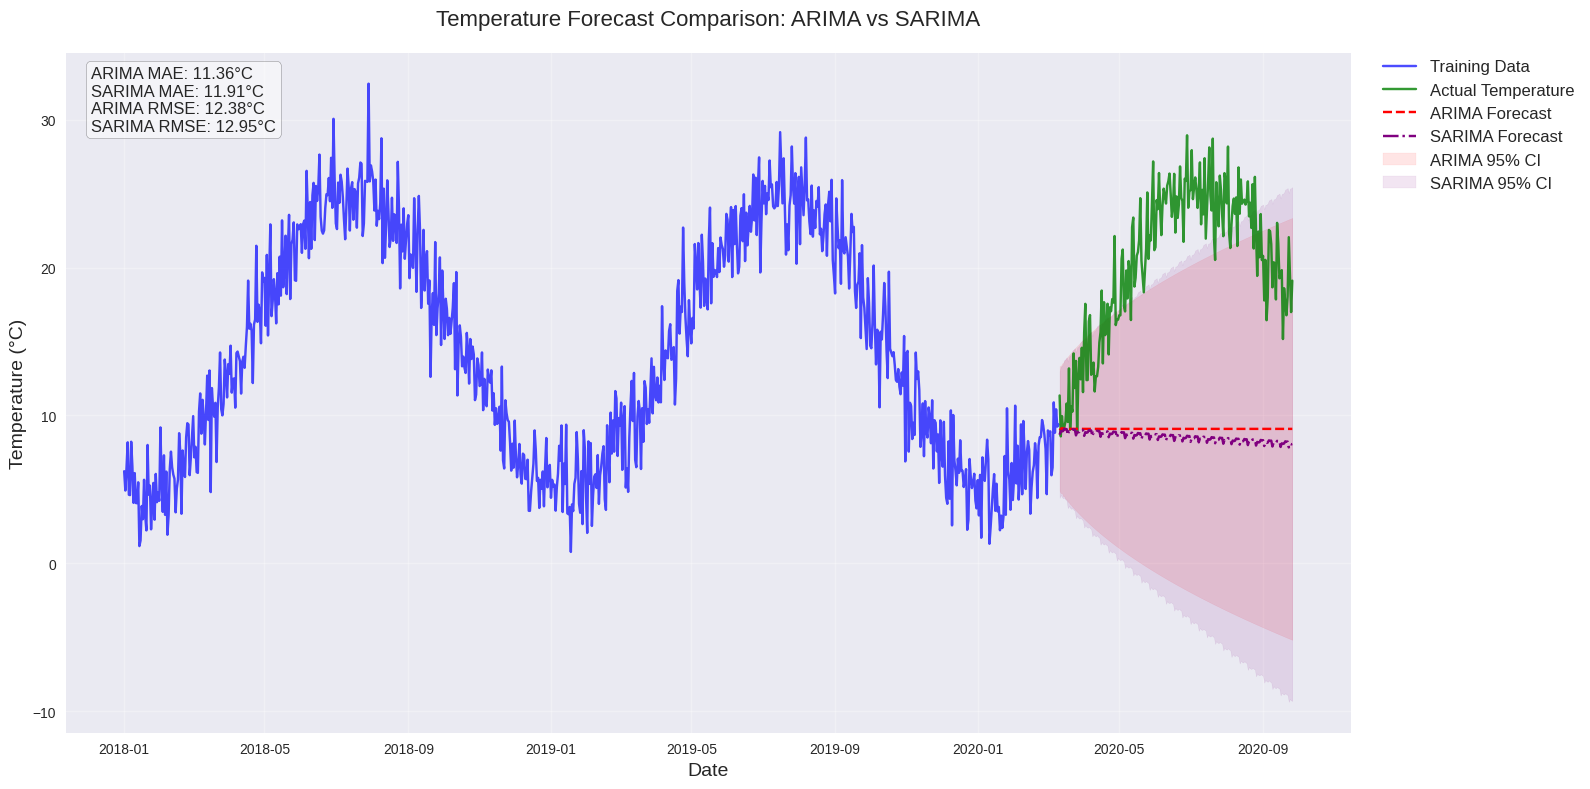

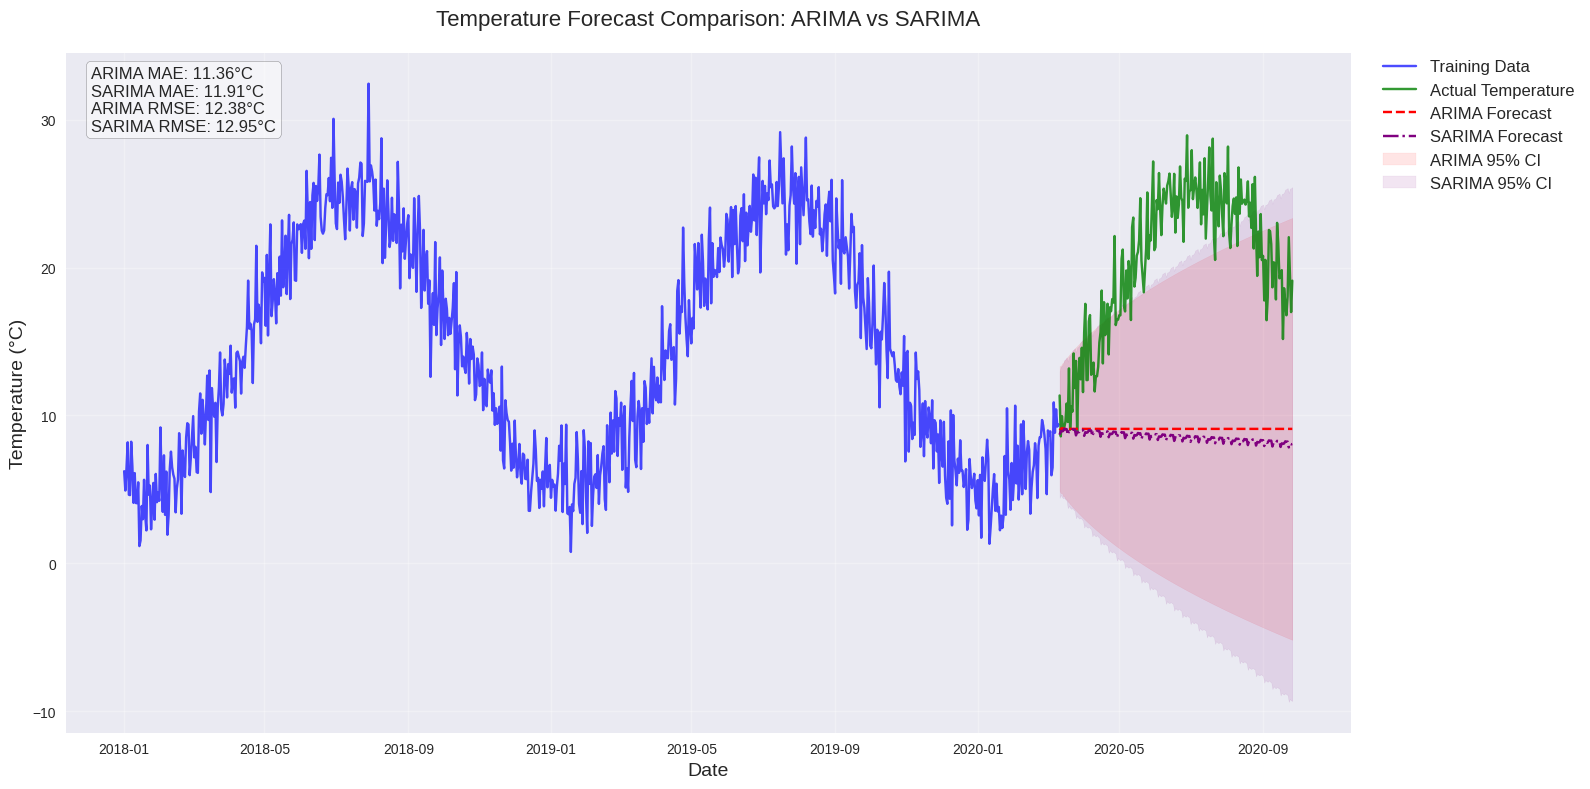

In [18]:
plt.figure(figsize=(16, 8))

# Plot training data
plt.plot(train.index, train, label='Training Data', color='blue', alpha=0.7)

# Plot test data
plt.plot(test.index, test, label='Actual Temperature', color='green', alpha=0.8)

# Plot ARIMA forecast
plt.plot(test.index, arima_forecast.predicted_mean,
         label='ARIMA Forecast', color='red', linestyle='--')

# Plot SARIMA forecast
plt.plot(test.index, sarima_forecast.predicted_mean,
         label='SARIMA Forecast', color='purple', linestyle='-.')

# Add confidence intervals
plt.fill_between(test.index,
                 arima_ci.iloc[:, 0],
                 arima_ci.iloc[:, 1],
                 color='red', alpha=0.1, label='ARIMA 95% CI')

plt.fill_between(test.index,
                 sarima_ci.iloc[:, 0],
                 sarima_ci.iloc[:, 1],
                 color='purple', alpha=0.1, label='SARIMA 95% CI')

# Customize plot
plt.title('Temperature Forecast Comparison: ARIMA vs SARIMA', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.grid(True, alpha=0.3)

# Move legend outside
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)

# Add text box with metrics
textstr = '\n'.join((
    f'ARIMA MAE: {arima_results["MAE"]:.2f}°C',
    f'SARIMA MAE: {sarima_results["MAE"]:.2f}°C',
    f'ARIMA RMSE: {arima_results["RMSE"]:.2f}°C',
    f'SARIMA RMSE: {sarima_results["RMSE"]:.2f}°C'))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gca().text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
              verticalalignment='top', bbox=props, fontsize=12)

plt.tight_layout()
plt.show()
